In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
from read_data import *
from nearNeighbors import *
from scipy import stats
from astropy import stats
import healpy as hp
from localBKG_and_interlopersHEALPix import *
# import healpy as hpy
from makeCutoutTableFunc import *
from plotHistogramProjections3D import *
from read_bricks import *
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
# Reads in data files for use in readData.py

hdu_sweep1 = fits.open('/Users/mtownsend/anaconda/Data/sweep-140p000-150p005-UVISTA1.fits') # this is one sweep file of the DECaLS data
hdu_sweep2 = fits.open('/Users/mtownsend/anaconda/Data/sweep-150p000-160p005-UVISTA2.fits') # this is one sweep file of the DECaLS data
# hdu_sweep3 = fits.open('/Users/mtownsend/anaconda/Data/sweep-210p050-220p055-AEGIS.fits') # this is one sweep file of the DECaLS data
# hdu_sweep4 = fits.open('/Users/mtownsend/anaconda/Data/sweep-180p060-190p065-GOODS-N.fits') # this is one sweep file of the DECaLS data


UVISTA1_data = hdu_sweep1[1].data
UVISTA2_data = hdu_sweep2[1].data
# AEGIS_data = hdu_sweep3[1].data
# GOODS_N_data = hdu_sweep4[1].data

ra_LS1, dec_LS1, gflux_LS1, rflux_LS1, zflux_LS1, w1flux_LS1, w2flux_LS1, w3flux_LS1, w4flux_LS1, gflux_ivar_LS1, rflux_ivar_LS1, zflux_ivar_LS1, w1flux_ivar_LS1, w2flux_ivar_LS1, w3flux_ivar_LS1, w4flux_ivar_LS1, mw_transmission_g_LS1, mw_transmission_r_LS1, mw_transmission_z_LS1, mw_transmission_w1_LS1, mw_transmission_w2_LS1, mw_transmission_w3_LS1, mw_transmission_w4_LS1 = readBricks(UVISTA1_data)
ra_LS2, dec_LS2, gflux_LS2, rflux_LS2, zflux_LS2, w1flux_LS2, w2flux_LS2, w3flux_LS2, w4flux_LS2, gflux_ivar_LS2, rflux_ivar_LS2, zflux_ivar_LS2, w1flux_ivar_LS2, w2flux_ivar_LS2, w3flux_ivar_LS2, w4flux_ivar_LS2, mw_transmission_g_LS2, mw_transmission_r_LS2, mw_transmission_z_LS2, mw_transmission_w1_LS2, mw_transmission_w2_LS2, mw_transmission_w3_LS2, mw_transmission_w4_LS2 = readBricks(UVISTA2_data)
# ra_GOODS_N, dec_GOODS_N, gflux_GOODS_N, rflux_GOODS_N, zflux_GOODS_N, w1flux_GOODS_N, w2flux_GOODS_N, w3flux_GOODS_N, w4flux_GOODS_N, gflux_ivar_GOODS_N, rflux_ivar_GOODS_N, zflux_ivar_GOODS_N, w1flux_ivar_GOODS_N, w2flux_ivar_GOODS_N, w3flux_ivar_GOODS_N, w4flux_ivar_GOODS_N, mw_transmission_g_GOODS_N, mw_transmission_r_GOODS_N, mw_transmission_z_GOODS_N, mw_transmission_w1_GOODS_N, mw_transmission_w2_GOODS_N, mw_transmission_w3_GOODS_N, mw_transmission_w4_GOODS_N = readBricks(GOODS_N_data)
# ra_AEGIS, dec_AEGIS, gflux_AEGIS, rflux_AEGIS, zflux_AEGIS, w1flux_AEGIS, w2flux_AEGIS, w3flux_AEGIS, w4flux_AEGIS, gflux_ivar_AEGIS, rflux_ivar_AEGIS, zflux_ivar_AEGIS, w1flux_ivar_AEGIS, w2flux_ivar_AEGIS, w3flux_ivar_AEGIS, w4flux_ivar_AEGIS, mw_transmission_g_AEGIS, mw_transmission_r_AEGIS, mw_transmission_z_AEGIS, mw_transmission_w1_AEGIS, mw_transmission_w2_AEGIS, mw_transmission_w3_AEGIS, mw_transmission_w4_AEGIS = readBricks(AEGIS_data)


print("end readdata")

# IMPORTANT NOTE: LRG data is the same for each.


done reading in DECaLS bricks
done reading in DECaLS bricks
end readdata


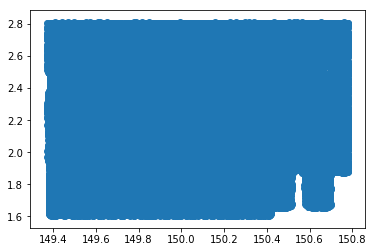

166641


In [3]:
# read in UV data

data_UV = open('/Users/mtownsend/eazy-photoz/inputs/OUTPUT/UVISTA_master_v4.1/UVISTA_final_v4.1.153-155.rf', 'r')
lines_UV = data_UV.readlines()[11:]

z = []
for line in lines_UV:
    p = line.split()
    z.append(float(p[1]))

z = np.array(z)

from astropy.io import ascii
data_cat = odata_cat = ascii.read("/Users/mtownsend/eazy-photoz/inputs/UVISTA_master_v4.1.cat")  

ra = data_cat['ra']
dec = data_cat['dec']
# z_spec = data_cat['z_spec']
use = data_cat['USE']
star = data_cat['star']
contamination = data_cat['contamination']
nan_contam = data_cat['nan_contam']
# z = data_cat['z_spec']

cut = np.where((use == 1.) & (star == 0.) & (contamination == 0.) & (nan_contam < 3.)) # & (Uflux > 0.) & (Vflux > 0.) & (zflux > 0.)) # & (zp > 0.))

ra_UV = ra[cut]
dec_UV = dec[cut]
z_peak = z[cut]

plt.scatter(ra_UV,dec_UV)
plt.show()

print(len(z_peak))


In [4]:
# data for photometric catalog for EAZY

gmag_LS1 = 22.5 - 2.5 * np.log10(gflux_LS1/mw_transmission_g_LS1)
gmag_LS2 = 22.5 - 2.5 * np.log10(gflux_LS2/mw_transmission_g_LS2)
rmag_LS1 = 22.5 - 2.5 * np.log10(rflux_LS1/mw_transmission_r_LS1)
rmag_LS2 = 22.5 - 2.5 * np.log10(rflux_LS2/mw_transmission_r_LS2)
zmag_LS1 = 22.5 - 2.5 * np.log10(zflux_LS1/mw_transmission_z_LS1)
zmag_LS2 = 22.5 - 2.5 * np.log10(zflux_LS2/mw_transmission_z_LS2)

ra_LS = np.concatenate([ra_LS1, ra_LS2])
dec_LS = np.concatenate([dec_LS1, dec_LS2])
gmag_LS = np.concatenate([gmag_LS1, gmag_LS2])
rmag_LS = np.concatenate([rmag_LS1, rmag_LS2])
zmag_LS = np.concatenate([zmag_LS1, zmag_LS2]) 

gflux_LS = np.concatenate([gflux_LS1/mw_transmission_g_LS1, gflux_LS2/mw_transmission_g_LS2])
rflux_LS = np.concatenate([rflux_LS1/mw_transmission_r_LS1, rflux_LS2/mw_transmission_r_LS2])
zflux_LS = np.concatenate([zflux_LS1/mw_transmission_z_LS1, zflux_LS2/mw_transmission_z_LS2])
w1flux_LS = np.concatenate([w1flux_LS1/mw_transmission_w1_LS1, w1flux_LS2/mw_transmission_w1_LS2])
w2flux_LS = np.concatenate([w2flux_LS1/mw_transmission_w2_LS1, w2flux_LS2/mw_transmission_w2_LS2])
w3flux_LS = np.concatenate([w3flux_LS1/mw_transmission_w3_LS1, w3flux_LS2/mw_transmission_w3_LS2])
w4flux_LS = np.concatenate([w4flux_LS1/mw_transmission_w4_LS1, w4flux_LS2/mw_transmission_w4_LS2])

gflux_ivar_LS = np.concatenate([gflux_ivar_LS1, gflux_ivar_LS2]) 
rflux_ivar_LS = np.concatenate([rflux_ivar_LS1, rflux_ivar_LS2]) 
zflux_ivar_LS = np.concatenate([zflux_ivar_LS1, zflux_ivar_LS2]) 
w1flux_ivar_LS = np.concatenate([w1flux_ivar_LS1, w1flux_ivar_LS2])
w2flux_ivar_LS = np.concatenate([w2flux_ivar_LS1, w2flux_ivar_LS2]) 
w3flux_ivar_LS = np.concatenate([w3flux_ivar_LS1, w3flux_ivar_LS2]) 
w4flux_ivar_LS = np.concatenate([w4flux_ivar_LS1, w4flux_ivar_LS2]) 
      
gflux_sigma = []
gflux_sigma = 1./np.sqrt(gflux_ivar_LS)

rflux_sigma = []
rflux_sigma = 1./np.sqrt(rflux_ivar_LS)
      
zflux_sigma = []
zflux_sigma = 1./np.sqrt(zflux_ivar_LS)
      
w1flux_sigma = []
w1flux_sigma = 1./np.sqrt(w1flux_ivar_LS)

w2flux_sigma = []
w2flux_sigma = 1./np.sqrt(w2flux_ivar_LS)
      
w3flux_sigma = []
w3flux_sigma = 1./np.sqrt(w3flux_ivar_LS)
      
w4flux_sigma = []
w4flux_sigma = 1./np.sqrt(w4flux_ivar_LS)


In [5]:
# match sources in UVista and LS catalogs

from astropy.coordinates import SkyCoord, match_coordinates_sky                                   
from astropy import units as u       

UVISTA_cat  = SkyCoord(ra=ra_UV*u.degree, dec=dec_UV*u.degree)

my_cat = SkyCoord(ra=ra_LS*u.degree, dec=dec_LS*u.degree) 

idx_UVISTA, sep2d_UVISTA, dist3d_UVISTA = match_coordinates_sky(UVISTA_cat, my_cat, nthneighbor=1)


In [6]:
sep2d_UVISTA_deg = sep2d_UVISTA.deg

sep_idx_UVISTA = idx_UVISTA[np.where(sep2d_UVISTA_deg <= 0.0003)]

print(len(sep_idx_UVISTA))



69987


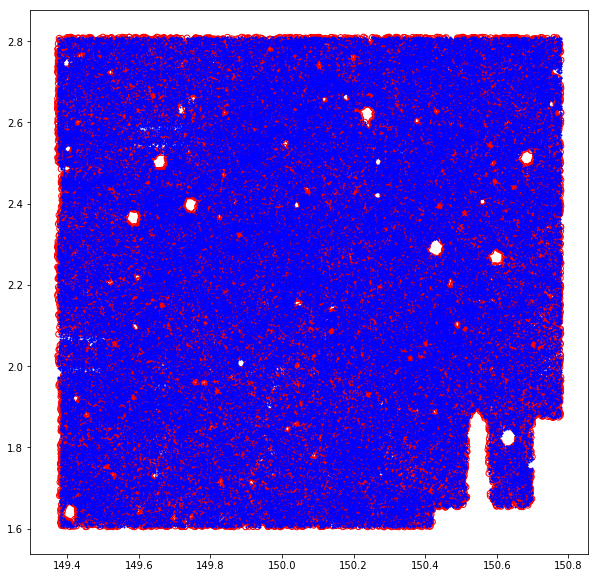

In [7]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.scatter(ra_LS[sep_idx_UVISTA], dec_LS[sep_idx_UVISTA], facecolors='none', edgecolors='r')
plt.scatter(ra_UV, dec_UV, c="blue", s=1)
plt.show()


In [36]:
# make a new catalog with ra, dec, LS photometry, LS photometry errors, and UV redshift
                               
np.savetxt('/Users/mtownsend/eazy-photoz/inputs/UV-LS-phot.cat', np.column_stack([gflux_LS[sep_idx_UVISTA], rflux_LS[sep_idx_UVISTA], zflux_LS[sep_idx_UVISTA], w1flux_LS[sep_idx_UVISTA], w2flux_LS[sep_idx_UVISTA], w3flux_LS[sep_idx_UVISTA], w4flux_LS[sep_idx_UVISTA], gflux_sigma[sep_idx_UVISTA], rflux_sigma[sep_idx_UVISTA], zflux_sigma[sep_idx_UVISTA], w1_sigma[sep_idx_UVISTA], w2_sigma[sep_idx_UVISTA], w3_sigma[sep_idx_UVISTA], w4_sigma[sep_idx_UVISTA], z_peak[np.where(ra_LS[sep_idx_UVISTA])]]))

print(len(ra_LS[sep_idx_UVISTA]))
print(len(gflux_LS[sep_idx_UVISTA]))
print(len(z_peak[np.where(ra_LS[sep_idx_UVISTA])]))
                                                                    

/Users/mtownsend/anaconda/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


69987
69987
69987


In [8]:
# calculate rest frame z-band luminosity

data_UV = open('/Users/mtownsend/eazy-photoz/inputs/OUTPUT/UV_LS_OUTPUT/UV_LS_main_output.294.rf', 'r')
lines_UV = data_UV.readlines()[10:]

distmod = []
gflux = []
redshift = []
for line in lines_UV:
    p = line.split()
    redshift.append(float(p[1]))
    distmod.append(float(p[2]))
    gflux.append(float(p[5]))

DM = np.array(distmod)
Gflux = np.array(gflux)
zspec = np.array(redshift)

# K correction
K_correct = -2.5*np.log10((1. + zspec)**-1.)

# Absolute magnitude
gMag = -2.5*np.log10(Gflux) + 25. - DM - K_correct

# Calculate rest frame zmag

Msun_z = 4.50
Msun_g = 5.05
gLum = 10.**((gMag-Msun_g)/(-2.5))

log_gLum = np.log10(gLum)

print(len(log_gLum))
print(len(zspec))
# print(len(log_zLum[np.where(log_zLum == nan)]))
# new = np.concatenate([log_zLum])
# print(new.shape)


# for i in range(len(log_zLum)):
#     if np.isnan(log_zLum[i]):
#         print(i)
    

69987
69987


/Users/mtownsend/anaconda/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


In [9]:
# import matplotlib.pylab as plt 

# zbins = np.array([0.2, 0.25625, 0.3125, 0.36875, 0.425, 0.48125, 0.5375, 0.59375, 0.65])

# lum0 = log_zLum[np.where((zspec >= zbins[0]) & (zspec < zbins[1]))]
# print(lum0[np.where(lum0 > 10.5)])

# plt.hist(lum0)
# plt.show()


38818
38818
38818
38818
38818
----
69987
69987
69987
69987
69987


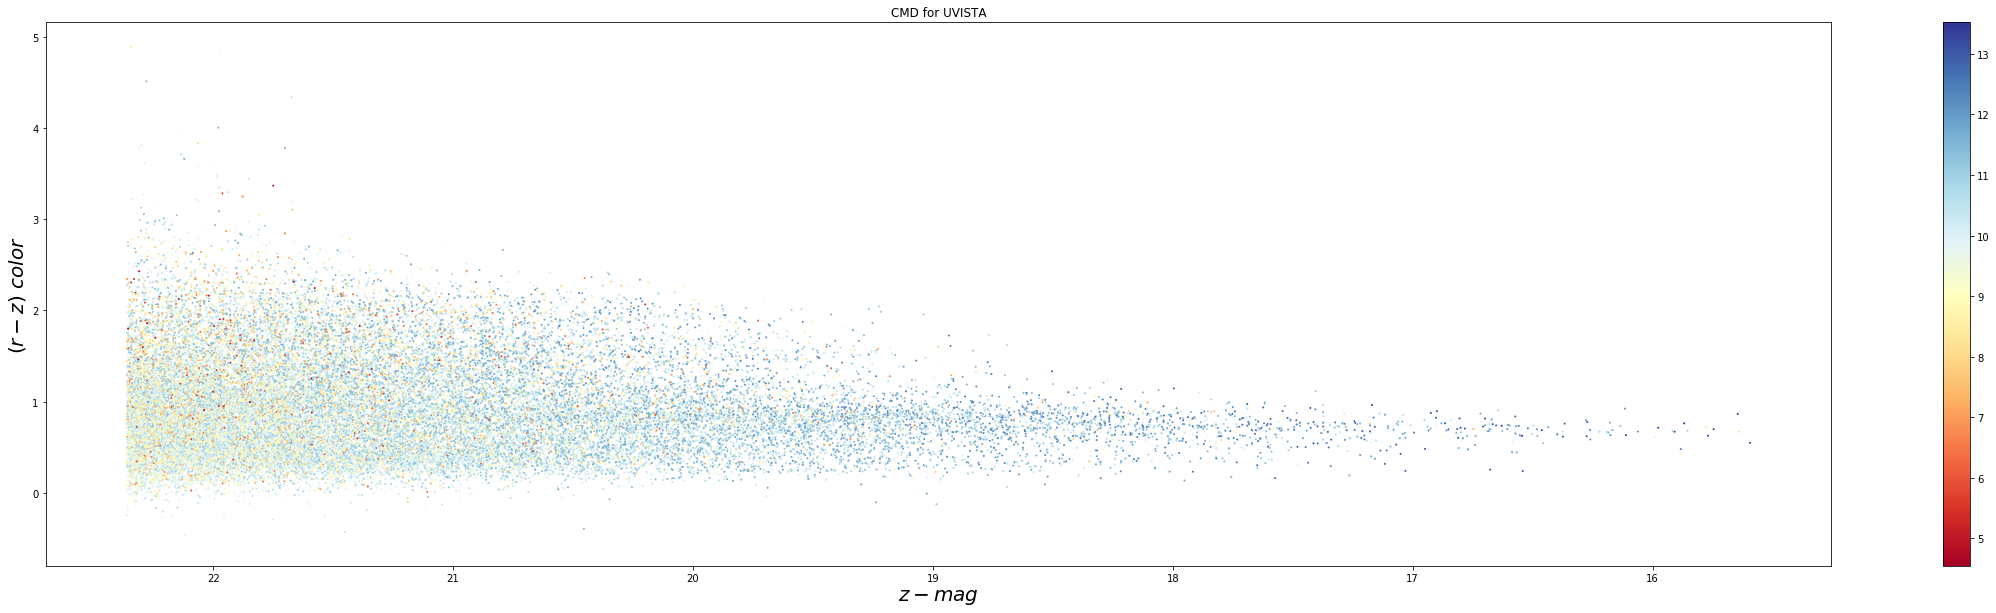

-2.6897259
9.514709


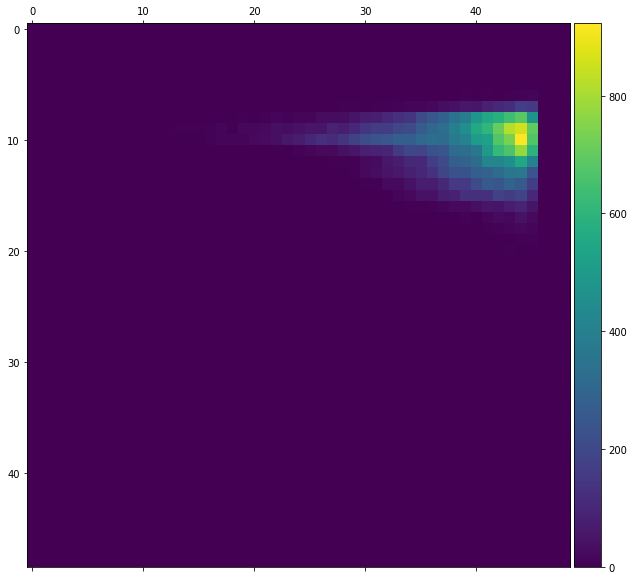

In [74]:
# calculate (g-r) and (r-z) colors
    
grcolor_UVLS_nocut = gmag_LS[sep_idx_UVISTA] - rmag_LS[sep_idx_UVISTA]
rzcolor_UVLS_nocut = rmag_LS[sep_idx_UVISTA] - zmag_LS[sep_idx_UVISTA]
zmag_UVLS_nocut = zmag_LS[sep_idx_UVISTA]

grcolor_UVLS = grcolor_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False))]
rzcolor_UVLS = rzcolor_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False))]
zmag_UVLS = zmag_UVLS_nocut[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False))]

zspec_UVLS = zspec[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False))]

log_gLum_cut = log_gLum[np.where((zmag_UVLS_nocut <= 22.36) & (np.isnan(log_gLum) == False))]
# print(len(log_zLum_cut[np.where(np.isnan(log_zLum_cut))]))
# print(log_zLum_cut)


print(len(zmag_UVLS))
print(len(grcolor_UVLS))
print(len(rzcolor_UVLS))
print(len(zspec_UVLS))
print(len(log_gLum_cut))
print('----')
print(len(zmag_UVLS_nocut))
print(len(grcolor_UVLS_nocut))
print(len(rzcolor_UVLS_nocut))
print(len(zspec))
print(len(log_gLum))

# print(len(z_peak[np.where(ra_LS[sep_idx_UVISTA])]))

rz_edges = [-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086]
zmag_edges = [13.22509, 13.425090026855468, 13.625090026855467, 13.825090026855467, 14.025090026855466, 14.225090026855465, 14.425090026855464, 14.625090026855464, 14.825090026855463, 15.025090026855462, 15.225090026855462, 15.425090026855461, 15.62509002685546, 15.82509002685546, 16.02509002685546, 16.225090026855458, 16.425090026855457, 16.625090026855457, 16.825090026855456, 17.025090026855455, 17.225090026855455, 17.425090026855454, 17.625090026855453, 17.825090026855452, 18.02509002685545, 18.22509002685545, 18.42509002685545, 18.62509002685545, 18.82509002685545, 19.025090026855448, 19.225090026855447, 19.425090026855447, 19.625090026855446, 19.825090026855445, 20.025090026855445, 20.225090026855444, 20.425090026855443, 20.625090026855442, 20.82509002685544, 21.02509002685544, 21.22509002685544, 21.42509002685544, 21.62509002685544, 21.825090026855438, 22.025090026855437, 22.225090026855437, 22.425090026855436, 22.625090026855435, 22.825090026855435, 23.025090026855434]
gr_edges = [-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765]

H2D, xedges_nouse, yedges_nouse = np.histogram2d(rzcolor_UVLS, zmag_UVLS, bins=(rz_edges, zmag_edges), density=False)

H1, nouse_edges = np.histogramdd((rzcolor_UVLS, zmag_UVLS, grcolor_UVLS), bins=(rz_edges, zmag_edges, gr_edges), density=False)

# make 2D projections of 3D histogram
# rz_v_zmag = H1[:, :, :].sum(axis=2)
# rz_vs_zmag = np.fliplr(rz_v_zmag)
# gr_v_zmag = H1[:, :, :].sum(axis=0)
# gr_vs_zmag = np.flipud(gr_v_zmag.T)
# gr_v_rz = H1[:, :, :].sum(axis=1)
# gr_vs_rz = np.flipud(gr_v_rz.T)


# print(rz_vs_zmag)
# print()
# print()
# print(gr_vs_zmag)
# print()
# print()
# print(gr_vs_rz)
# print()
# print()
# print(H1.shape)
# print(type(H1))

# plt.matshow(rz_vs_zmag)
# plt.show()

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(zmag_UVLS, rzcolor_UVLS, s=1, c=log_gLum_cut, cmap=cm)
plt.gca().invert_xaxis()
plt.title("CMD for UVISTA")
plt.xlabel(r'$z-mag$', fontsize=20)
plt.ylabel(r'$(r-z)$ $color$', fontsize=20)
plt.colorbar(sc)
plt.show()

print(min(grcolor_UVLS))
print(max(grcolor_UVLS))

plt.figure()
ax = plt.gca()
im = ax.matshow(H2D,interpolation='none')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
# plt.savefig('/Users/mtownsend/Desktop/compareCMDs/UV_CMD_hist.pdf'.format(i))    
plt.show()


In [75]:
# temp = []
# lumlist = np.zeros_like(H2D, dtype=float)

# y = zmag_UVLS
# x = rzcolor_UVLS
# yedges = zmag_edges
# xedges = rz_edges
# lum = log_zLum_cut

def lum_array(H, x, y, lum, xedges, yedges):
    temp = []
    lumlist = np.zeros_like(H2D, dtype=float)

    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            for m in range(len(x)):
                if ((x[m] >= xedges[i]) & (x[m] <= xedges[i+1]) & (y[m] >= yedges[j]) & (y[m] <= yedges[j+1])):
                    temp.append(lum[m])
                    if (len(temp) > 0.):
                        lumlist[i][j] = np.median(list(temp))
                    else:
                        lumlist[i][j] = 0.
        temp = []
        
#     lumarray = np.array(lumlist)
    return lumlist
# print(lumarray[np.where(lumarray == 'nan')])



In [79]:
# init = min(grcolor_UVLS)
# fin = max(grcolor_UVLS)
# interval = 0.5
# num = (fin-init)/interval
# color_range, step = np.linspace(init, fin, num=int(num), retstep=True)

# x = rzcolor_UVLS
# y = zmag_UVLS
# lum = log_gLum_cut

# median_lum = lum_array(H2D, x, y, lum, rz_edges, zmag_edges)

# print(len(median_lum))
# print(type(median_lum))
# print(median_lum[0])

# init = min(grcolor_UVLS)
# fin = max(grcolor_UVLS)
# interval = 0.5
# num = (fin-init)/interval
# color_range, step = np.linspace(init, fin, num=int(num), retstep=True)
# print(len(color_range))
# print(step)


# median_lum = []
# for i in range(len(color_range)-1):
#     x = rzcolor_UVLS[np.where((grcolor_UVLS >= color_range[i]) & (grcolor_UVLS <= color_range[i+1]))]
#     y = zmag_UVLS[np.where((grcolor_UVLS >= color_range[i]) & (grcolor_UVLS <= color_range[i+1]))]
#     lum = log_gLum_cut[np.where((grcolor_UVLS >= color_range[i]) & (grcolor_UVLS <= color_range[i+1]))]
#     lumlist = lum_array(H2D, x, y, lum, rz_edges, zmag_edges)
#     median_lum.append(lumlist)
#     print(i)

# print('----')
# print(len(median_lum))
# print(median_lum[0])


zinit = 0.2
zfin = 0.65
interval = 0.05
num = (zfin-zinit)/interval
zrange, step = np.linspace(0.2, 0.65, num=int(num), retstep=True)
print(zrange)
print(step)

median_lum = []
for i in range(len(zrange)-1):
    x = rzcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    y = zmag_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    lum = log_gLum_cut[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    lumlist = lum_array(H2D, x, y, lum, rz_edges, zmag_edges)
    median_lum.append(lumlist)
    print(i)

[0.2     0.25625 0.3125  0.36875 0.425   0.48125 0.5375  0.59375 0.65   ]
0.05625
0
1
2
3
4
5
6
7


In [18]:
print(type(lumlist))
print(type(lumlist[0]))

# a = [2,1,5,8,10,nan,13,6]
# print(np.median(a))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


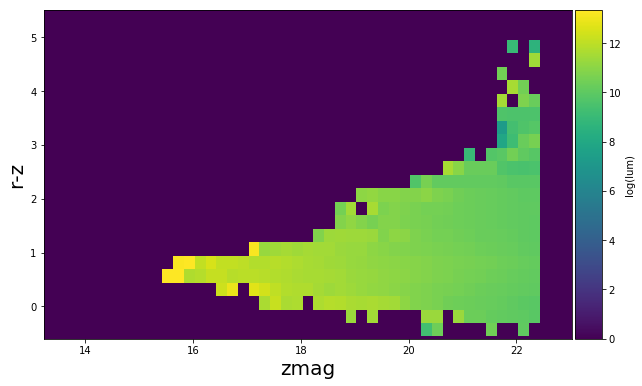

In [38]:
# print(lumarray[30:49])

# print(type(median_lum[0]))

plt.figure()
ax = plt.gca()
im = ax.imshow(median_lum, extent=(zmag_edges[0], zmag_edges[-1], rz_edges[0], rz_edges[-1]), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax, label='log(lum)')
ax.set_ylim([-0.6,5.5])
ax.set_xlabel('zmag',fontsize=20)
ax.set_ylabel('r-z',fontsize=20)
plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/30April2020/UV_CMD_lum_hist-v2.pdf'.format(i))    


24
0.5306276238482931


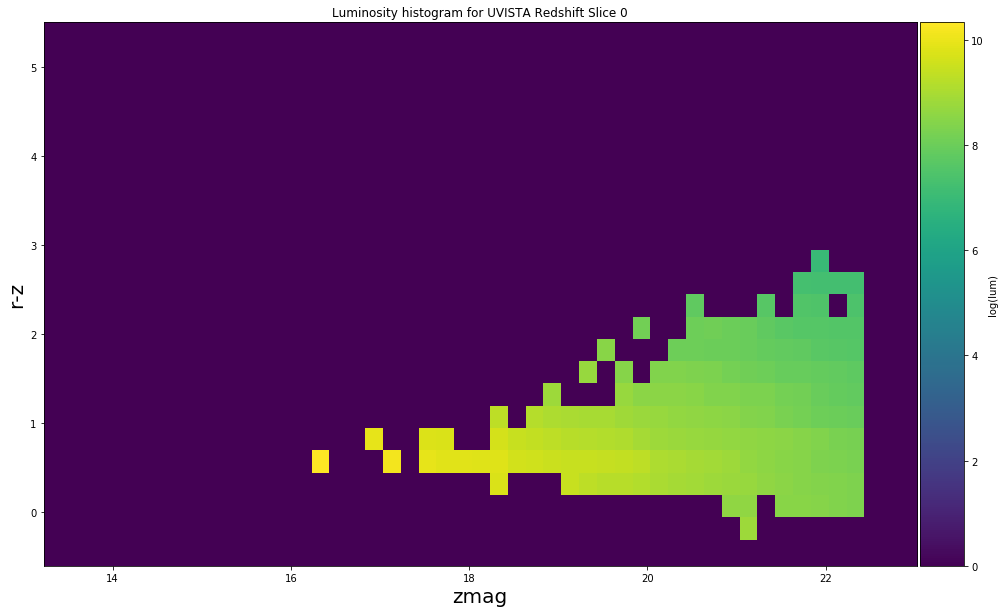

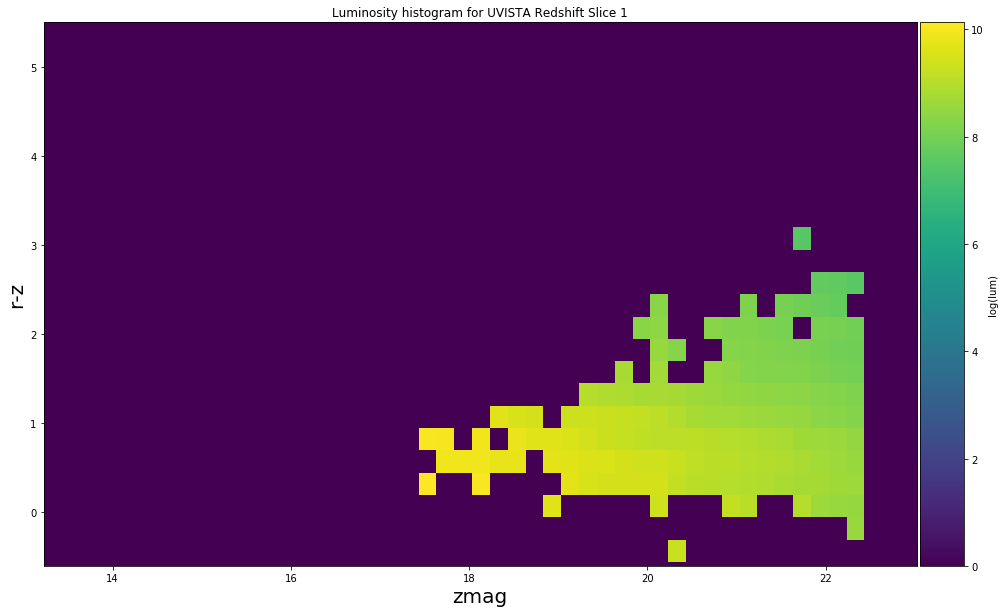

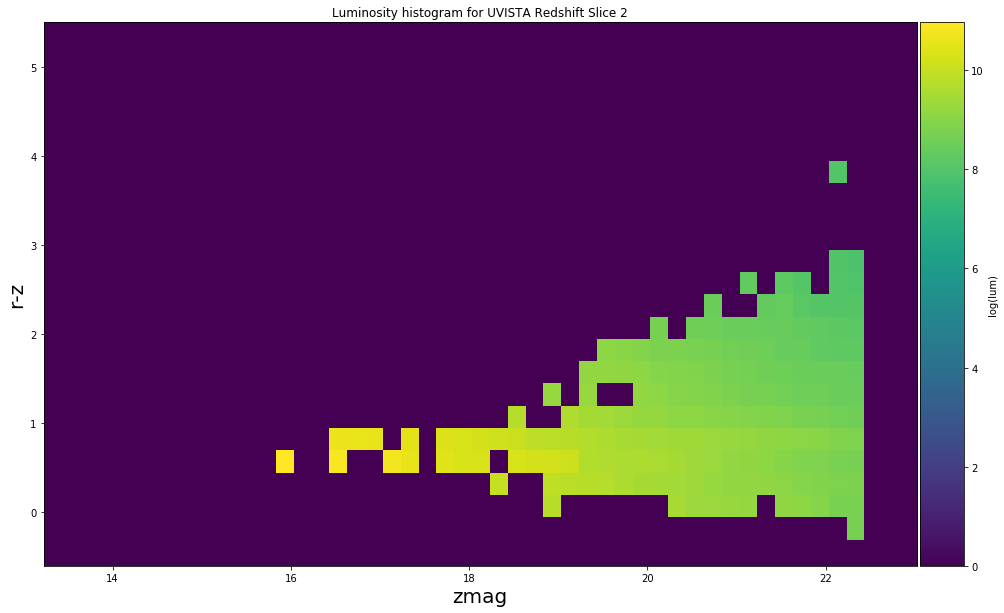

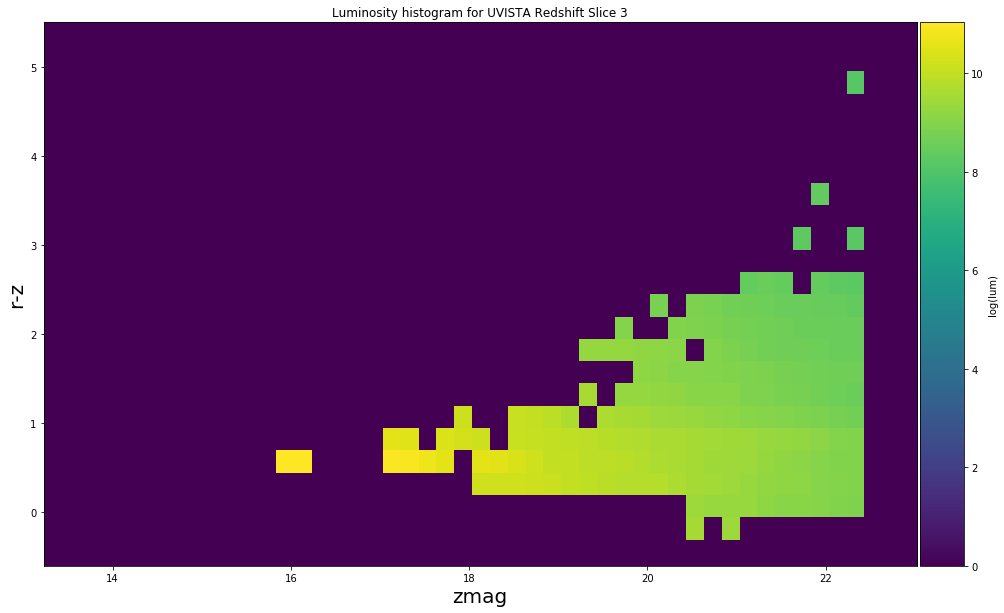

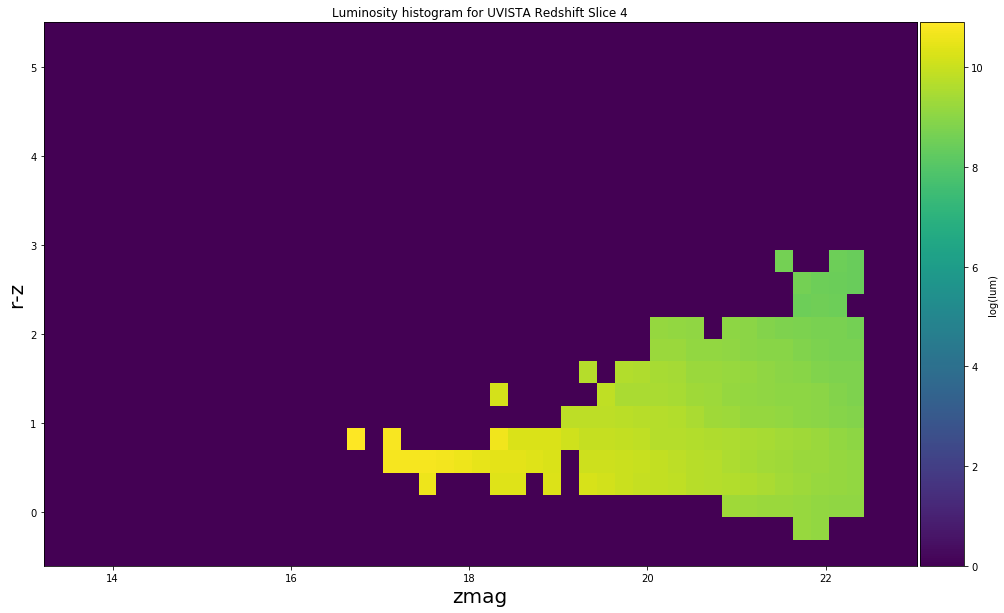

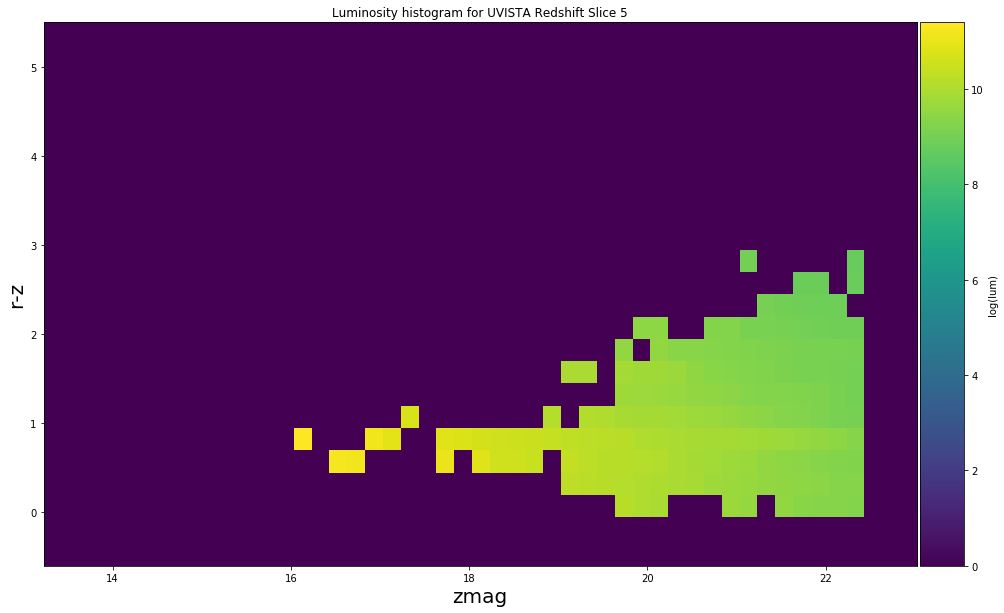

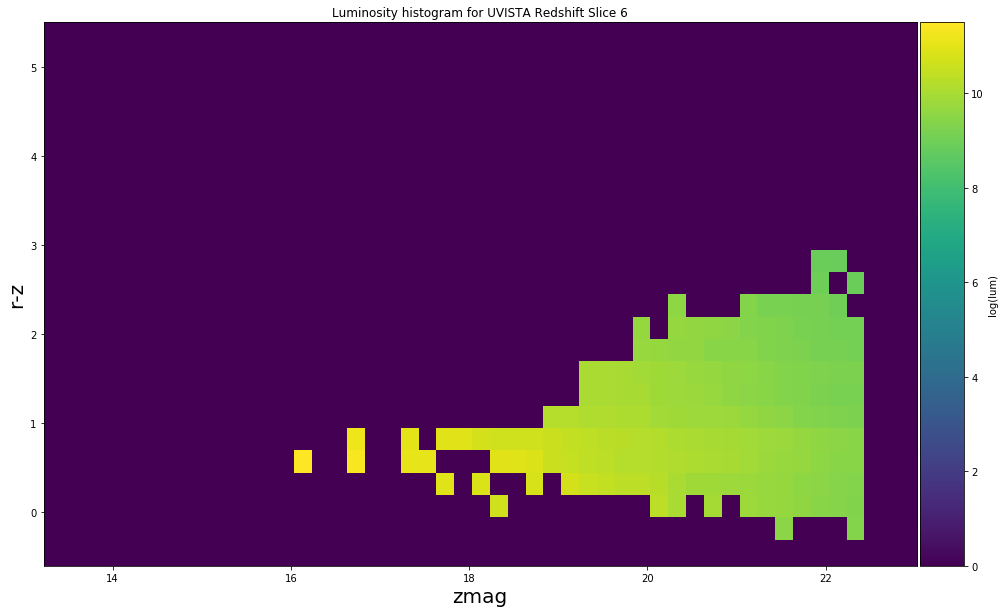

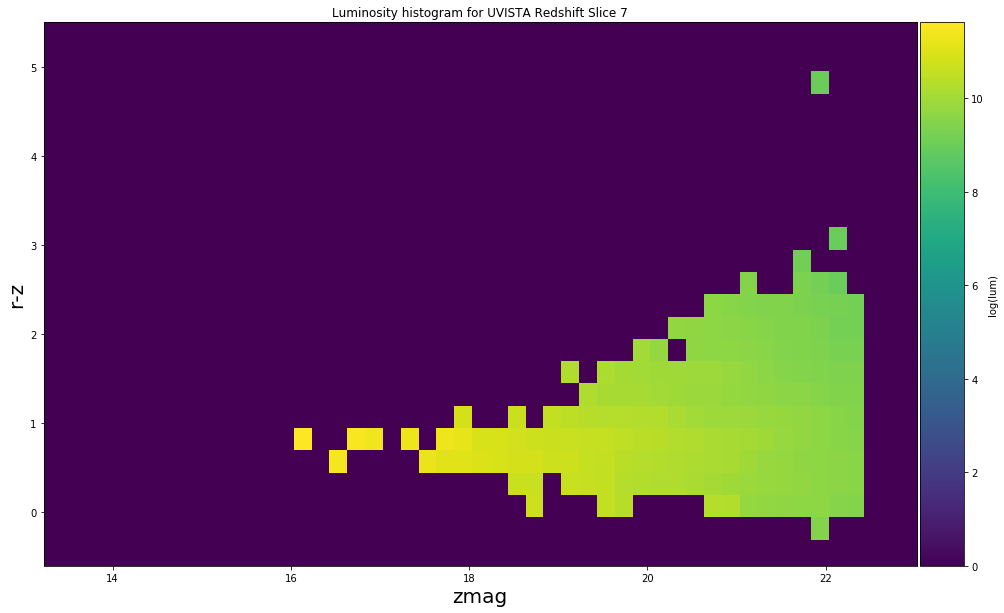

In [81]:
init = min(grcolor_UVLS)
fin = max(grcolor_UVLS)
interval = 0.5
num = (fin-init)/interval
color_range, step = np.linspace(init, fin, num=int(num), retstep=True)
print(len(color_range))
print(step)


for i in range(len(median_lum)):
#     cm = plt.cm.get_cmap('RdYlBu')
#     sc = plt.scatter(zmag_UVLS[np.where((grcolor_UVLS >= color_range[i]) & (grcolor_UVLS <= color_range[i+1]))], rzcolor_UVLS[np.where((grcolor_UVLS >= color_range[i]) & (grcolor_UVLS <= color_range[i+1]))], c=log_zLum_cut[np.where((grcolor_UVLS >= color_range[i]) & (grcolor_UVLS <= color_range[i+1]))], cmap=cm)
#     plt.gca().invert_xaxis()
#     plt.title("CMD for UVISTA Slice {}".format(i))
#     plt.xlabel(r'$z-mag$', fontsize=20)
#     plt.ylabel(r'$(r-z)$ $color$', fontsize=20)
#     plt.colorbar(sc)
    plt.figure()
    ax = plt.gca()
    im = ax.imshow(median_lum[i], extent=(zmag_edges[0], zmag_edges[-1], rz_edges[0], rz_edges[-1]), origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    ax.set_title("Luminosity histogram for UVISTA Redshift Slice {}".format(i))
    plt.colorbar(im, cax=cax, label='log(lum)')
    ax.set_ylim([-0.6,5.5])
    ax.set_xlabel('zmag',fontsize=20)
    ax.set_ylabel('r-z',fontsize=20)
    plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/30April2020/UV_lum_hist_redshiftslice{}.pdf'.format(i))    

    plt.show()

# for i in range(len(color_range)-1):
#     print(len(grcolor_UVLS[np.where((grcolor_UVLS >= color_range[i]) & (grcolor_UVLS <= color_range[i+1]))]))
#     print(len(zmag_UVLS[np.where((grcolor_UVLS >= color_range[i]) & (grcolor_UVLS <= color_range[i+1]))]))
#     print(len(rzcolor_UVLS[np.where((grcolor_UVLS >= color_range[i]) & (grcolor_UVLS <= color_range[i+1]))]))
#     print(len(log_zLum_cut[np.where((grcolor_UVLS >= color_range[i]) & (grcolor_UVLS <= color_range[i+1]))]))
#     print('----')



In [12]:
zinit = 0.2
zfin = 0.65
interval = 0.05
num = (zfin-zinit)/interval
zrange, step = np.linspace(0.2, 0.65, num=int(num), retstep=True)
print(zrange)
print(step)

[0.2     0.25625 0.3125  0.36875 0.425   0.48125 0.5375  0.59375 0.65   ]
0.05625


In [22]:
# making color-color-magnitude diagram for 3DHST galaxies at each redshift

# rz_edges = [-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086]
# zmag_edges = [13.22509, 13.425090026855468, 13.625090026855467, 13.825090026855467, 14.025090026855466, 14.225090026855465, 14.425090026855464, 14.625090026855464, 14.825090026855463, 15.025090026855462, 15.225090026855462, 15.425090026855461, 15.62509002685546, 15.82509002685546, 16.02509002685546, 16.225090026855458, 16.425090026855457, 16.625090026855457, 16.825090026855456, 17.025090026855455, 17.225090026855455, 17.425090026855454, 17.625090026855453, 17.825090026855452, 18.02509002685545, 18.22509002685545, 18.42509002685545, 18.62509002685545, 18.82509002685545, 19.025090026855448, 19.225090026855447, 19.425090026855447, 19.625090026855446, 19.825090026855445, 20.025090026855445, 20.225090026855444, 20.425090026855443, 20.625090026855442, 20.82509002685544, 21.02509002685544, 21.22509002685544, 21.42509002685544, 21.62509002685544, 21.825090026855438, 22.025090026855437, 22.225090026855437, 22.425090026855436, 22.625090026855435, 22.825090026855435, 23.025090026855434]
# gr_edges = [-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765]

# hist_per_redshift = []
# for i in range(len(zrange)-1):
#     H1, nouse_edges = np.histogramdd((rzcolor[np.where((zspec > zrange[i]) & (zspec <= zrange[i+1]))], zmag[np.where((zspec > zrange[i]) & (zspec <= zrange[i+1]))], grcolor[np.where((zspec > zrange[i]) & (zspec <= zrange[i+1]))]), bins=(rz_edges, zmag_edges, gr_edges), density=False)
#     hist_per_redshift.append(H1)
    
# # print(masks.shape)
# print(hist_per_redshift[0].shape)
# # test = hist_per_redshift[0]
# # print(test[np.where(test > 0.)])
    
    

(49, 49, 49)


In [11]:

rz_edges = [-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086]
zmag_edges = [13.22509, 13.425090026855468, 13.625090026855467, 13.825090026855467, 14.025090026855466, 14.225090026855465, 14.425090026855464, 14.625090026855464, 14.825090026855463, 15.025090026855462, 15.225090026855462, 15.425090026855461, 15.62509002685546, 15.82509002685546, 16.02509002685546, 16.225090026855458, 16.425090026855457, 16.625090026855457, 16.825090026855456, 17.025090026855455, 17.225090026855455, 17.425090026855454, 17.625090026855453, 17.825090026855452, 18.02509002685545, 18.22509002685545, 18.42509002685545, 18.62509002685545, 18.82509002685545, 19.025090026855448, 19.225090026855447, 19.425090026855447, 19.625090026855446, 19.825090026855445, 20.025090026855445, 20.225090026855444, 20.425090026855443, 20.625090026855442, 20.82509002685544, 21.02509002685544, 21.22509002685544, 21.42509002685544, 21.62509002685544, 21.825090026855438, 22.025090026855437, 22.225090026855437, 22.425090026855436, 22.625090026855435, 22.825090026855435, 23.025090026855434]
gr_edges = [-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765]

Hstar, nouse_edges = np.histogramdd((rzcolor_UVLS, zmag_UVLS, grcolor_UVLS), bins=(rz_edges, zmag_edges, gr_edges), density=False)

print(len(rzcolor_UVLS))
print(len(zmag_UVLS))
print(len(grcolor_UVLS))


38818
38818
38818


In [12]:
def making_masks(H1, lum_limit, x, y, z, lum, xedges, yedges, zedges):
    
    # lum_limit == luminosity threshold
    # x,y,z == arrays involved in the 3D histogram
    # lum = luminosity array; same size as x (or y or z)
    # xedges,yedges,zedges = boundaries to search for x,y,z
    
    import numpy as np
    
    temp = []
    lumlist = np.zeros_like(H1, dtype=float)
#     indexlist = np.zeros((2,2,2),dtype=list)

    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            for k in range(len(zedges)-1):
                for m in range(len(x)):
                    if ((x[m] >= xedges[i]) & (x[m] <= xedges[i+1]) & (y[m] >= yedges[j]) & (y[m] <= yedges[j+1]) & (z[m] >= zedges[k]) & (z[m] <= zedges[k+1])):
                        temp.append(lum[m])
                    if (len(temp) > 0.):
                        lumlist[i][j][k] = np.median(list(temp))
#                         indexlist[i][j][k] = list(temp)
                    else:
                        lumlist[i][j][k] = 0.
            temp = []
               
    test_array = lumlist

    mask_array = np.empty_like(H1)
    for i in range(len(test_array)):
        for j in range(len(test_array[i])):
            for k in range(len(test_array[i][j])):
                if (test_array[i][j][k] > lum_limit):
                    mask_array[i][j][k] = 1
                else:
                    mask_array[i][j][k] = 0

    return mask_array



# rz_edges = [-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086]
# zmag_edges = [13.22509, 13.425090026855468, 13.625090026855467, 13.825090026855467, 14.025090026855466, 14.225090026855465, 14.425090026855464, 14.625090026855464, 14.825090026855463, 15.025090026855462, 15.225090026855462, 15.425090026855461, 15.62509002685546, 15.82509002685546, 16.02509002685546, 16.225090026855458, 16.425090026855457, 16.625090026855457, 16.825090026855456, 17.025090026855455, 17.225090026855455, 17.425090026855454, 17.625090026855453, 17.825090026855452, 18.02509002685545, 18.22509002685545, 18.42509002685545, 18.62509002685545, 18.82509002685545, 19.025090026855448, 19.225090026855447, 19.425090026855447, 19.625090026855446, 19.825090026855445, 20.025090026855445, 20.225090026855444, 20.425090026855443, 20.625090026855442, 20.82509002685544, 21.02509002685544, 21.22509002685544, 21.42509002685544, 21.62509002685544, 21.825090026855438, 22.025090026855437, 22.225090026855437, 22.425090026855436, 22.625090026855435, 22.825090026855435, 23.025090026855434]
# gr_edges = [-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765]

zinit = 0.2
zfin = 0.65
interval = 0.05
num = (zfin-zinit)/interval
zrange, step = np.linspace(zinit, zfin, num=int(num), retstep=True)
print(zrange)

masks = []
for i in range(len(zrange)-1):
    x = rzcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    y = zmag_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    z = grcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    lum = log_gLum_cut[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
    mask_array = making_masks(Hstar, 10.46, x, y, z, lum, rz_edges, zmag_edges, gr_edges)
    masks.append(mask_array)
    print(i)
    
# masks = []
# for i in range(len(zrange)-1):
#     x = rzcolor_UVLS[np.where((zspec_UVLS >= zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     y = zmag_UVLS[np.where((zspec_UVLS >= zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     z = grcolor_UVLS[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     lum = log_zLum_cut[np.where((zspec_UVLS > zrange[i]) & (zspec_UVLS <= zrange[i+1]))]
#     mask_array = making_masks(H1, 10.5, x, y, z, lum, rz_edges, zmag_edges, gr_edges)
#     masks.append(mask_array)
#     print(i)

print('----')
print(len(masks))
print(len(zrange))



[0.2     0.25625 0.3125  0.36875 0.425   0.48125 0.5375  0.59375 0.65   ]
0
1
2
3
4
5
6
7
----
8
9


In [14]:
import numpy as np

# print(masks[0])
# print(masks[0].shape)
mask0 = masks[0]
mask1 = masks[1]
mask2 = masks[2]
mask3 = masks[3]
mask4 = masks[4]
mask5 = masks[5]
mask6 = masks[6]
mask7 = masks[7]

# # f = open('Users/mtownsend/Desktop/masks.npz', 'w')
np.savez('/Users/mtownsend/Desktop/masks-v4.npz', mask0=mask0, mask1=mask1, mask2=mask2, mask3=mask3, mask4=mask4, mask5=mask5, mask6=mask6, mask7=mask7)
# # f.close()

data = np.load('/Users/mtownsend/Desktop/masks-v4.npz')
# print(data['mask0'])



In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

d0 = data['mask0']
d1 = data['mask1']
d2 = data['mask2']
d3 = data['mask3']
d4 = data['mask4']
d5 = data['mask5']
d6 = data['mask6']
d7 = data['mask7']

# print(d0[1])

print(np.where(d2 == 1))

a = d0[0]
print(a.shape)
print(a[np.where(a == 1.)])
b = d2[1]
print(b.shape)
print(b[np.where(b == 1.)])
c = d2[2]
print(c.shape)
print(c[np.where(c == 1.)])

# x = np.concatenate([d0[0]])
# # x.flatten()
# print(x.shape)
# y = np.concatenate([d0[1]])
# print(y.shape)
# z = np.concatenate([d0[2]])
# print(z.shape)


# fig= plt.figure()
# ax = fig.add_subplot(1,1,1, projection= '3d')
# ax.scatter(x,y,z)

# ax.plot(x, z, 'r+', zdir='y', zs=1.5)
# ax.plot(y, z, 'g+', zdir='x', zs=-0.5)
# ax.plot(x, y, 'k+', zdir='z', zs=-1.5)

# # ax.set_xlim([-0.5, 1.5])
# # ax.set_ylim([-0.5, 1.5])
# # ax.set_zlim([-1.5, 1.5])

# plt.show()



(array([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10]), array([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17,

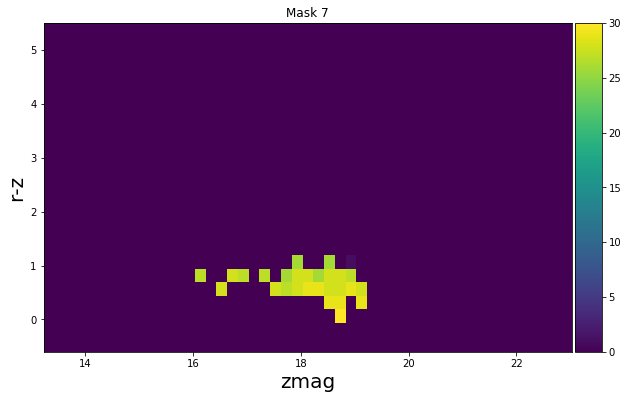

In [32]:
d0 = data['mask0']
d1 = data['mask1']
d2 = data['mask2']
d3 = data['mask3']
d4 = data['mask4']
d5 = data['mask5']
d6 = data['mask6']
d7 = data['mask7']

rz_v_zmag = d7[:, :, :].sum(axis=2)
# rz_vs_zmag = np.fliplr(rz_v_zmag)

plt.figure()
ax = plt.gca()
im = ax.imshow(rz_v_zmag, extent=(zmag_edges[0], zmag_edges[-1], rz_edges[0], rz_edges[-1]), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("Mask 7")
ax.set_ylim([-0.6,5.5])
ax.set_xlabel('zmag',fontsize=20)
ax.set_ylabel('r-z',fontsize=20)
plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/30April2020/mask_hist7-v1.pdf'.format(i))   
plt.show()


In [33]:
# Reads in data files for use in readData.py

hdu_north = fits.open('/Users/mtownsend/anaconda/Data/survey-dr8-north-specObj-dr14.fits') # this matches SDSS LRGs to MzLS/BASS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS and LEGACY SURVEYS
hdu_south = fits.open('/Users/mtownsend/anaconda/Data/survey-dr8-south-specObj-dr14.fits')# this matches SDSS LRGs to DECaLS;
                                                                 # ONLY GIVES SOURCES THAT ARE IN SDSS and LEGACY SURVEYS
hdu_sdss = fits.open('/Users/mtownsend/anaconda/Data/specObj-dr14.fits') # this is SDSS redshifts etc for LRGs
hdu_sweep1 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p005-250p010-dr8.fits') # this is one sweep file of the DECaLS data
hdu_sweep2 = fits.open('/Users/mtownsend/anaconda/Data/sweep-240p010-250p015-dr8.fits') # this is one sweep file of the DECaLS data

SpecObj_data_north = hdu_north[1].data
SpecObj_data_south = hdu_south[1].data
SDSS_data = hdu_sdss[1].data
DECaLS_data1 = hdu_sweep1[1].data
DECaLS_data2 = hdu_sweep2[1].data

id_LRG1, plate_LRG1, fiberid_LRG1, specobjid_LRG1, ra_LRG1, dec_LRG1, ra_BKG1, dec_BKG1, z_LRG1, gflux_LRG1, rflux_LRG1, zflux_LRG1, w1flux_LRG1, w2flux_LRG1, w3flux_LRG1, w4flux_LRG1, gflux_BKG1, rflux_BKG1, zflux_BKG1, w1flux_BKG1, w2flux_BKG1, w3flux_BKG1, w4flux_BKG1, gflux_ivar_LRG1, rflux_ivar_LRG1, zflux_ivar_LRG1, w1flux_ivar_LRG1, w2flux_ivar_LRG1, w3flux_ivar_LRG1, w4flux_ivar_LRG1, gflux_ivar_BKG1, rflux_ivar_BKG1, zflux_ivar_BKG1, w1flux_ivar_BKG1, w2flux_ivar_BKG1, w3flux_ivar_BKG1, w4flux_ivar_BKG1, mw_transmission_g_LRG1, mw_transmission_r_LRG1, mw_transmission_z_LRG1, mw_transmission_g_BKG1, mw_transmission_r_BKG1, mw_transmission_z_BKG1, mw_transmission_w1_LRG1, mw_transmission_w2_LRG1, mw_transmission_w3_LRG1, mw_transmission_w4_LRG1, mw_transmission_w1_BKG1, mw_transmission_w2_BKG1, mw_transmission_w3_BKG1, mw_transmission_w4_BKG1 = readData(SpecObj_data_south, SDSS_data, DECaLS_data1)
id_LRG2, plate_LRG2, fiberid_LRG2, specobjid_LRG2, ra_LRG2, dec_LRG2, ra_BKG2, dec_BKG2, z_LRG2, gflux_LRG2, rflux_LRG2, zflux_LRG2, w1flux_LRG2, w2flux_LRG2, w3flux_LRG2, w4flux_LRG2, gflux_BKG2, rflux_BKG2, zflux_BKG2, w1flux_BKG2, w2flux_BKG2, w3flux_BKG2, w4flux_BKG2, gflux_ivar_LRG2, rflux_ivar_LRG2, zflux_ivar_LRG2, w1flux_ivar_LRG2, w2flux_ivar_LRG2, w3flux_ivar_LRG2, w4flux_ivar_LRG2, gflux_ivar_BKG2, rflux_ivar_BKG2, zflux_ivar_BKG2, w1flux_ivar_BKG2, w2flux_ivar_BKG2, w3flux_ivar_BKG2, w4flux_ivar_BKG2, mw_transmission_g_LRG2, mw_transmission_r_LRG2, mw_transmission_z_LRG2, mw_transmission_g_BKG2, mw_transmission_r_BKG2, mw_transmission_z_BKG2, mw_transmission_w1_LRG2, mw_transmission_w2_LRG2, mw_transmission_w3_LRG2, mw_transmission_w4_LRG2, mw_transmission_w1_BKG2, mw_transmission_w2_BKG2, mw_transmission_w3_BKG2, mw_transmission_w4_BKG2 = readData(SpecObj_data_south, SDSS_data, DECaLS_data2)


print("end readdata")

# IMPORTANT NOTE: LRG data is the same for each.

done reading in SDSS
done reading in DECaLS-SDSS matched file
done creating unique IDs for matched file
done making LRG only cut
done reading in DECaLS bricks
length of id_ALL:  4488579
done creating unique IDs for brick file
done identifying LRGs in survey brick
631147
done making survey cuts
done reading in SDSS
done reading in DECaLS-SDSS matched file
done creating unique IDs for matched file
done making LRG only cut
done reading in DECaLS bricks
length of id_ALL:  4076998
done creating unique IDs for brick file
done identifying LRGs in survey brick
249137
done making survey cuts
end readdata


2037
1823


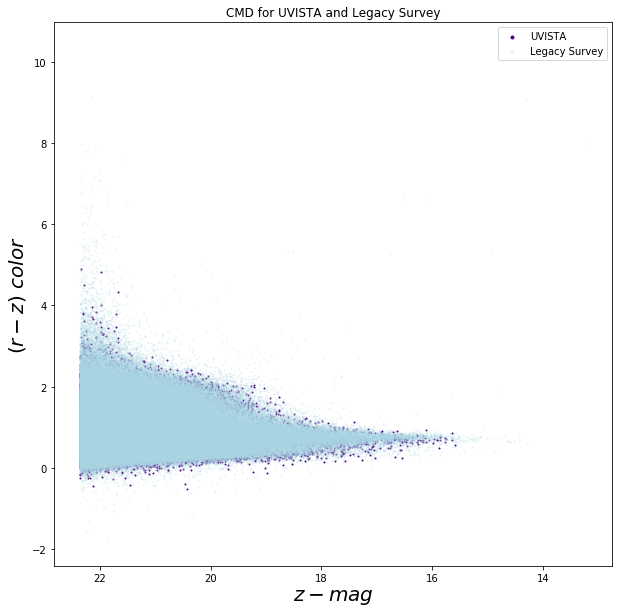

In [34]:
# calculate LRG magnitudes

gmag_LRG_nocuts = 22.5 - 2.5 * np.log10(gflux_LRG1/mw_transmission_g_LRG1)
rmag_LRG_nocuts = 22.5 - 2.5 * np.log10(rflux_LRG1/mw_transmission_r_LRG1)
zmag_LRG_nocuts = 22.5 - 2.5 * np.log10(zflux_LRG1/mw_transmission_z_LRG1)

print(len(zmag_LRG_nocuts))

# calculate BKG magnitudes

gmag_BKG1 = 22.5 - 2.5 * np.log10(gflux_BKG1)
gmag_BKG2 = 22.5 - 2.5 * np.log10(gflux_BKG2)
rmag_BKG1 = 22.5 - 2.5 * np.log10(rflux_BKG1)
rmag_BKG2 = 22.5 - 2.5 * np.log10(rflux_BKG2)
zmag_BKG1 = 22.5 - 2.5 * np.log10(zflux_BKG1)
zmag_BKG2 = 22.5 - 2.5 * np.log10(zflux_BKG2)

gmag_BKG_nocuts = np.concatenate([gmag_BKG1, gmag_BKG2])
rmag_BKG_nocuts = np.concatenate([rmag_BKG1, rmag_BKG2])
zmag_BKG_nocuts = np.concatenate([zmag_BKG1, zmag_BKG2])
  
    
# zmag_cut_test = np.concatenate([zmag_LRG_nocuts, zmag_BKG])
    
# calculate LRG (g-r) and (r-z) colors
    
grcolor_LRG_nocuts = gmag_LRG_nocuts - rmag_LRG_nocuts
rzcolor_LRG_nocuts = rmag_LRG_nocuts - zmag_LRG_nocuts
    
# calculate BKG (g-r) and (r-z) colors
    
grcolor_BKG_nocuts = gmag_BKG_nocuts - rmag_BKG_nocuts
rzcolor_BKG_nocuts = rmag_BKG_nocuts - zmag_BKG_nocuts

# create full list of LRG attributes

ra_LRG_nocuts = ra_LRG1
ra_BKG_nocuts = np.concatenate([ra_BKG1, ra_BKG2])
dec_LRG_nocuts = dec_LRG1
dec_BKG_nocuts = np.concatenate([dec_BKG1, dec_BKG2])
z_LRG_nocuts = z_LRG1
id_LRG_nocuts = id_LRG1

ra_nocuts = np.concatenate([ra_LRG_nocuts, ra_BKG_nocuts])
dec_nocuts = np.concatenate([dec_LRG_nocuts, dec_BKG_nocuts])

# cut for zmag brighter than 22.36

ra_LRG_temp = ra_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
dec_LRG_temp = dec_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
id_LRG_temp = id_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
z_LRG_temp = z_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
gmag_LRG_temp = gmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
rmag_LRG_temp = rmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
zmag_LRG_temp = zmag_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
grcolor_LRG_temp = grcolor_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
rzcolor_LRG_temp = rzcolor_LRG_nocuts[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]

# calculate rest-frame magnitudes

# K_correct = -2.5*np.log10((1. + z_LRG_temp)**-1.)
# Mz = zmag_LRG_temp - DM_arr - K_correct
# Lz = 10.**((Mz-Msun_z)/(-2.5))
# log_Lz = np.log10(Lz)

ra_LRG = ra_LRG_temp #[np.where(log_Lz > 10.5)]
dec_LRG = dec_LRG_temp # [np.where(log_Lz > 10.5)]
id_LRG = id_LRG_temp # [np.where(log_Lz > 10.5)]
z_LRG = z_LRG_temp # [np.where(log_Lz > 10.5)]

# plate_LRG = plate_LRG1[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]
# fiberid_LRG = fiberid_LRG1[np.where((z_LRG_nocuts >= 0.2) & (z_LRG_nocuts <= 0.65) & (zmag_LRG_nocuts <= 22.36))]

gmag_LRG = gmag_LRG_temp # [np.where(log_Lz > 10.5)]
rmag_LRG = rmag_LRG_temp # [np.where(log_Lz > 10.5)]
zmag_LRG = zmag_LRG_temp # [np.where(log_Lz > 10.5)]
grcolor_LRG = grcolor_LRG_temp # [np.where(log_Lz > 10.5)]
rzcolor_LRG = rzcolor_LRG_temp# [np.where(log_Lz > 10.5)]

ra_BKG = ra_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
dec_BKG = dec_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]

gmag_BKG = gmag_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
rmag_BKG = rmag_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
zmag_BKG = zmag_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
grcolor_BKG = grcolor_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]
rzcolor_BKG = rzcolor_BKG_nocuts[np.where(zmag_BKG_nocuts <= 22.36)]

# combine LRG and BKG lists

ra = np.concatenate([ra_LRG, ra_BKG])
dec = np.concatenate([dec_LRG, dec_BKG])

gmag = np.concatenate([gmag_LRG, gmag_BKG])
rmag = np.concatenate([rmag_LRG, rmag_BKG])
zmag = np.concatenate([zmag_LRG, zmag_BKG])

grcolor = np.concatenate([grcolor_LRG, grcolor_BKG]) 
rzcolor = np.concatenate([rzcolor_LRG, rzcolor_BKG]) 

print(len(ra_LRG))


plt.scatter(zmag_UVLS, rzcolor_UVLS, s=1, c='indigo', label="UVISTA")
plt.scatter(zmag, rzcolor, s=1, c='lightblue', alpha=0.2, label='Legacy Survey')
plt.gca().invert_xaxis()
plt.title("CMD for UVISTA and Legacy Survey")
plt.xlabel(r'$z-mag$', fontsize=20)
plt.ylabel(r'$(r-z)$ $color$', fontsize=20)
plt.legend(loc='upper right', markerscale=3)
# plt.savefig('/Users/mtownsend/Desktop/compareCMDs/UVISTA_and_LS_CMD-v1.pdf')

plt.show()


In [35]:
DTT_Gyr, age_Gyr, zage_Gyr, DCMR_Mpc, DCMR_Gyr, DA_Mpc, DA_Gyr, kpc_DA, DL_Mpc, DL_Gyr, V_Gpc = cosmoCalcfunc(z_LRG)

print("end cosmoCalc")

end cosmoCalc


In [36]:
rz_edges = [-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086]
zmag_edges = [13.22509, 13.425090026855468, 13.625090026855467, 13.825090026855467, 14.025090026855466, 14.225090026855465, 14.425090026855464, 14.625090026855464, 14.825090026855463, 15.025090026855462, 15.225090026855462, 15.425090026855461, 15.62509002685546, 15.82509002685546, 16.02509002685546, 16.225090026855458, 16.425090026855457, 16.625090026855457, 16.825090026855456, 17.025090026855455, 17.225090026855455, 17.425090026855454, 17.625090026855453, 17.825090026855452, 18.02509002685545, 18.22509002685545, 18.42509002685545, 18.62509002685545, 18.82509002685545, 19.025090026855448, 19.225090026855447, 19.425090026855447, 19.625090026855446, 19.825090026855445, 20.025090026855445, 20.225090026855444, 20.425090026855443, 20.625090026855442, 20.82509002685544, 21.02509002685544, 21.22509002685544, 21.42509002685544, 21.62509002685544, 21.825090026855438, 22.025090026855437, 22.225090026855437, 22.425090026855436, 22.625090026855435, 22.825090026855435, 23.025090026855434]
gr_edges = [-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765]

H1, nouse_edges = np.histogramdd((rzcolor, zmag, grcolor), bins=(rz_edges, zmag_edges, gr_edges), density=False)


# print(nouse_edges)

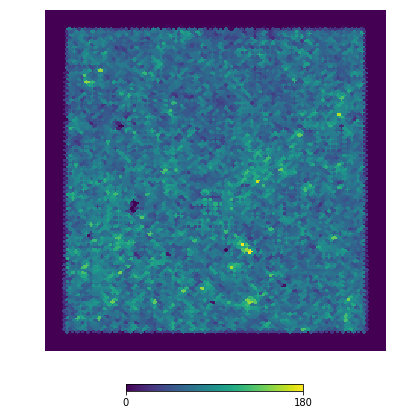

length phi:  519348


In [37]:
# Make HEALPix map using just RA/Dec; end up with a density plot

nside = 1024
npixel = hp.nside2npix(nside)

# Convert ra/dec into theta/phi
theta = []
phi = []

for i in range(len(ra)):
    theta.append(np.radians(90. - dec[i]))
    phi.append(np.radians(ra[i]))
    
m = hp.ang2pix(nside, theta, phi)
map_ = np.bincount(m, minlength=npixel)
hp.gnomview(map_, xsize=225, rot=(-116.5, 9), flip='geo', cmap='viridis', notext=True, title="")
# plt.rcParams.update({'font.size':20})
# plt.savefig('/Users/mtownsend/Desktop/survey-density.jpg')
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/HEALPix-survey-density-v2.pdf')
plt.show()

print('length phi: ', len(phi))

# Convert angles theta and phi to pixel numbers

pixnums = hp.ang2pix(nside, theta, phi, nest=True)


In [38]:
distance = 0.5 # must be in Mpc

distance_kpc, near, gal_tree, dist, index, nn1 = nearNeighbor(distance, kpc_DA, ra_LRG, dec_LRG, ra_BKG, dec_BKG, zmag_LRG, zmag_BKG, rzcolor_LRG, rzcolor_BKG, grcolor_LRG, grcolor_BKG, nouse_edges)

print('end nearNeighbor')


end nearNeighbor


mean number of near neighbors is 47.37410861217773
median number of near neighbors is 41.0
standard deviation of near neighbor is 23.851534505334982
standard error is 0.5587816536680068


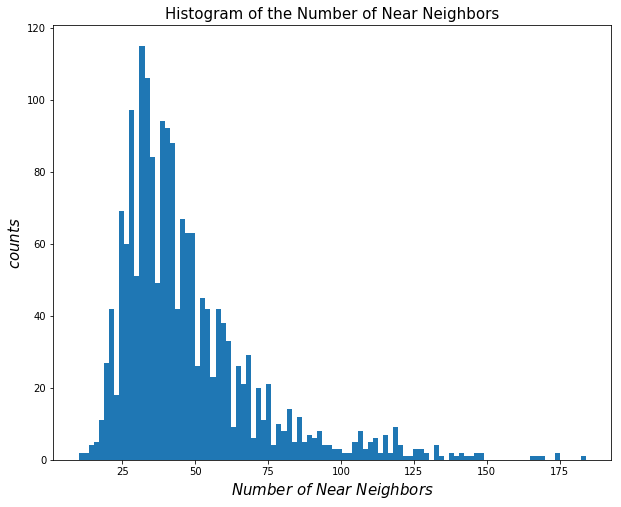

In [39]:
totalNear(near)

plt.show()

In [40]:
inner_dist = 0.4 # in deg
outer_dist = 0.5 # in deg

Nbkg, indices, omega, localBKG = localBKG_and_interlopersHEALPix(nside, inner_dist, outer_dist, ra_LRG, dec_LRG, pixnums, zmag, rzcolor, grcolor, nouse_edges, distance_kpc, kpc_DA)

omega = np.array(omega)

print("end bkg")

end bkg


mean number of interlopers is 36.48040431977798
median number of interlopers is 32.26296824728518
standard deviation of interloper is 17.293140891821423
standard error is 0.4051349342946642


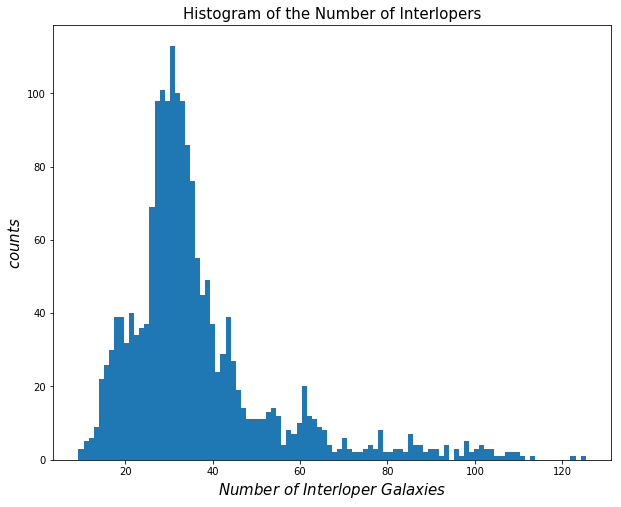

In [41]:
totalNbkg(Nbkg)

plt.show()

Nbkg = np.array(Nbkg)

In [42]:
Nsat = np.array(near) - np.array(Nbkg)

print(Nsat[0].shape)
print("end Nsat")

(49, 49, 49)
end Nsat


mean number of satellites is 10.893704292399752
median number of satellites is 8.594618015771369
standard deviation of satellites is 16.107462370334574
standard error is 0.3773574592308747


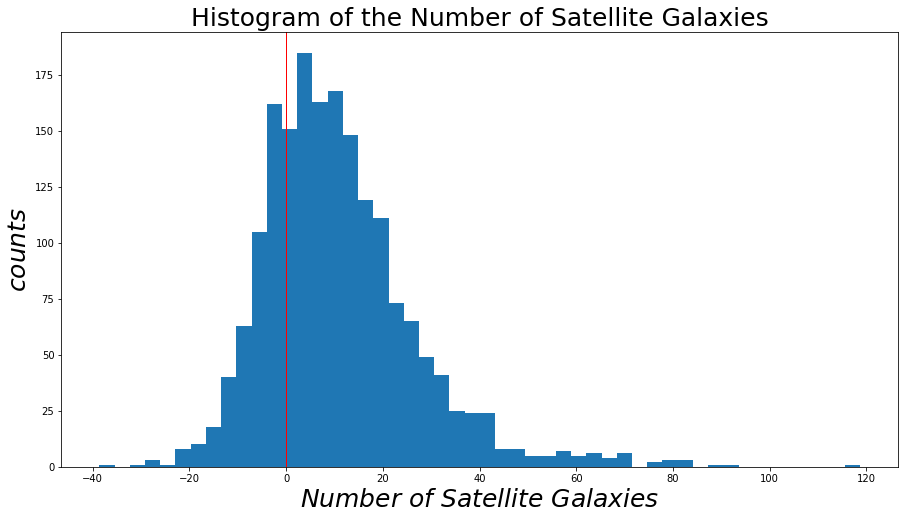

In [43]:
totalNsat(Nsat)

# plt.savefig('/Users/mtownsend/Desktop/maskedNsat.jpg')
plt.show()

In [44]:
# make a dictionary of Nsat in different redshift slices

# defines redshift slices
zinit = 0.2
zfin = 0.65
interval = 0.05
num = (zfin-zinit)/interval
zrange, step = np.linspace(zinit, zfin, num=int(num), retstep=True)
print(zrange)

NsatDict = {}
keys = range(len(zrange)-1)
for i in keys:
    NsatDict[i] = Nsat[np.where((z_LRG > zrange[i]) & (z_LRG < zrange[i+1]))]
#     Dict[i] = zrange[i]

maskDict = {}
for i in range(len(zrange)-1):
    maskDict[i] = masks[i]

print(len(NsatDict))
print(len(maskDict))

[0.2     0.25625 0.3125  0.36875 0.425   0.48125 0.5375  0.59375 0.65   ]
8
8


In [45]:

newNsat = {}
for i in range(len(maskDict)):
    newNsat[i] = NsatDict[i] * maskDict[i]
    
print(len(newNsat[0]))
print(len(newNsat[1]))
print(len(newNsat[2]))
print(len(newNsat[3]))
print(len(newNsat[4]))
print(len(newNsat[5]))
print(len(newNsat[6]))
print(len(newNsat[7]))

    
maskedNsat = []
for i in range(len(newNsat)):
    for j in range(len(NsatDict[i])):
        maskedNsat.append(newNsat[i][j])
    
print(len(maskedNsat))

113
88
173
166
271
417
376
219
1823


In [76]:
newNsat0 = newNsat[0]
newNsat1 = newNsat[1]
newNsat2 = newNsat[2]
newNsat3 = newNsat[3]
newNsat4 = newNsat[4]
newNsat5 = newNsat[5]
newNsat6 = newNsat[6]
newNsat7 = newNsat[7]


mean number of satellites is 0.04800621246693689
median number of satellites is -0.07068460479500484
standard deviation of satellites is 0.6753460765485215
standard error is 0.015821665367801593


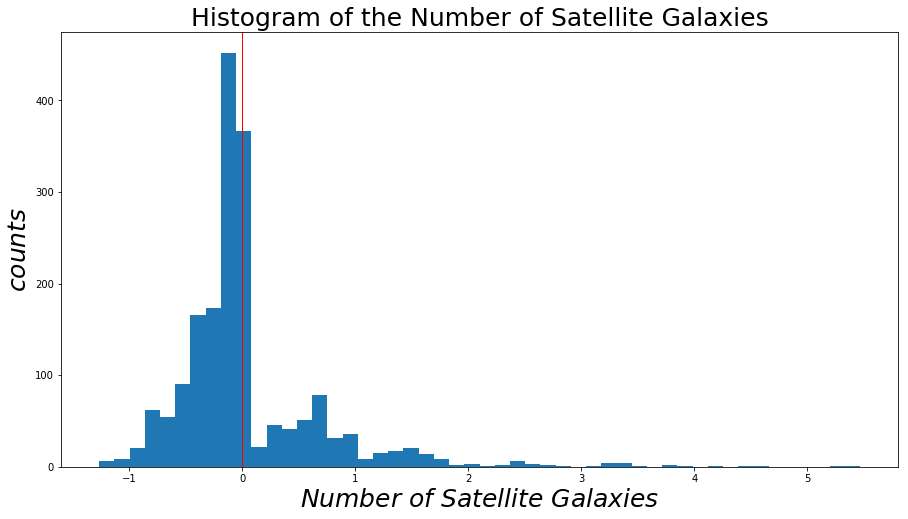

In [46]:
totalNsat(maskedNsat)

# plt.savefig('/Users/mtownsend/Desktop/maskedNsat.jpg')
plt.show()

mean number of satellites is 20.099984489640832
median number of satellites is 20.552154839164547
standard deviation of satellites is 26.878764121908258
standard error is 2.5398044791190943


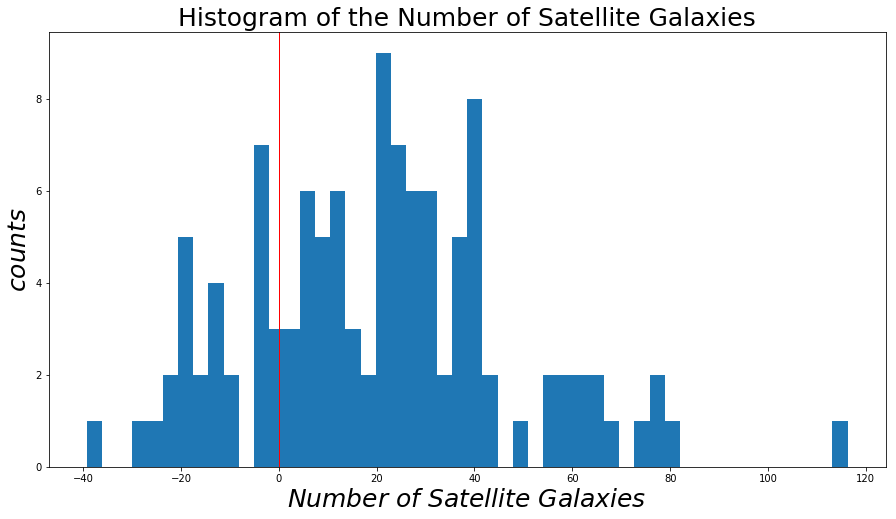

In [79]:
totalNsat(newNsat0)

# plt.savefig('/Users/mtownsend/Desktop/maskedNsat0.jpg')
plt.show()

mean number of satellites is 15.462486231790793
median number of satellites is 11.042842814946098
standard deviation of satellites is 20.960156607816426
standard error is 2.2471646631403224


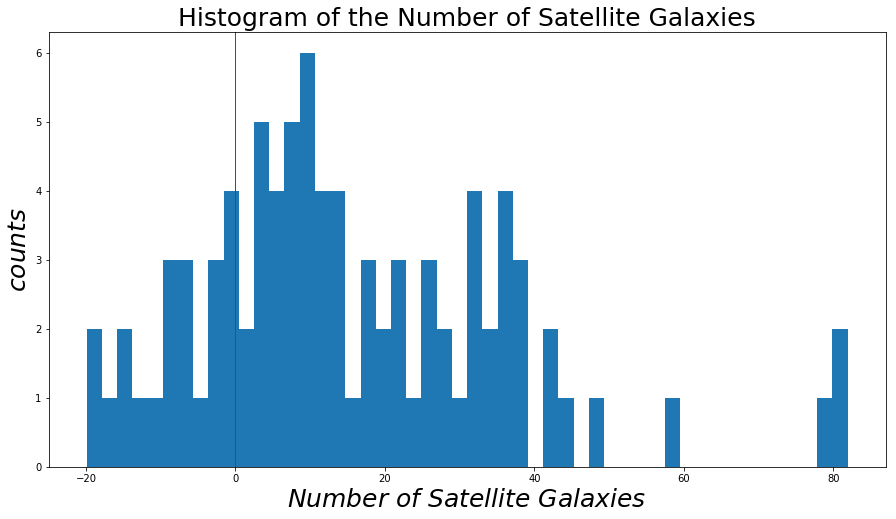

In [80]:
totalNsat(newNsat1)

# plt.savefig('/Users/mtownsend/Desktop/maskedNsat1.jpg')
plt.show()

mean number of satellites is 16.17932069305446
median number of satellites is 12.362416618252063
standard deviation of satellites is 20.517332683530405
standard error is 1.564431950638405


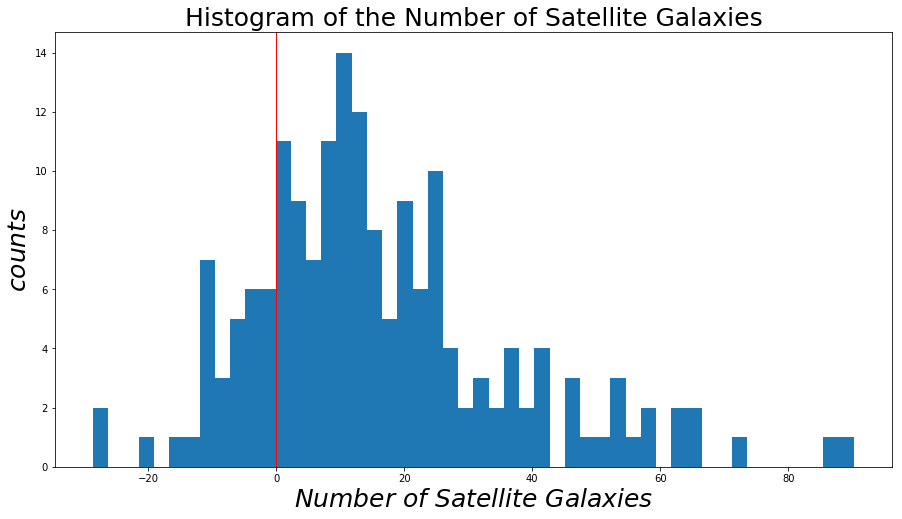

In [81]:
totalNsat(newNsat2)

# plt.savefig('/Users/mtownsend/Desktop/maskedNsat2.jpg')
plt.show()

mean number of satellites is 10.422281851038584
median number of satellites is 6.22735069920723
standard deviation of satellites is 17.80339131076137
standard error is 1.3859921337922159


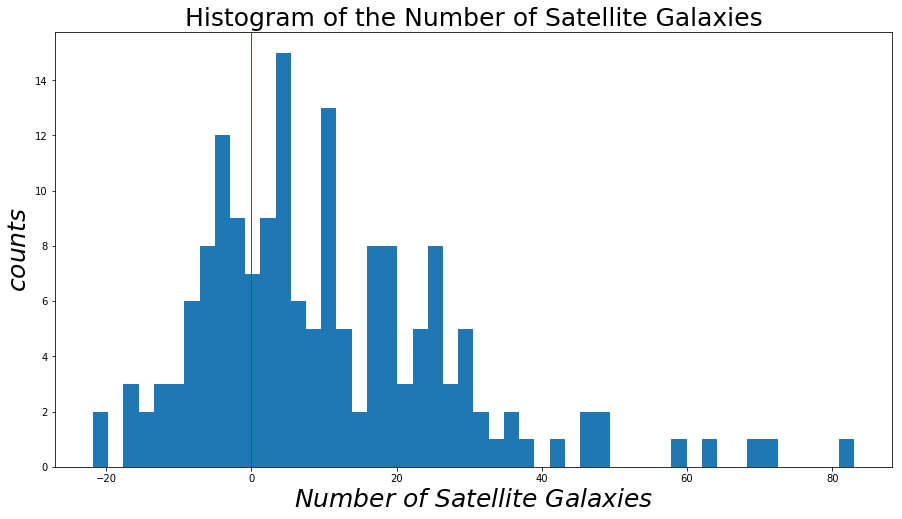

In [82]:
totalNsat(newNsat3)

# plt.savefig('/Users/mtownsend/Desktop/maskedNsat3.jpg')
plt.show()

mean number of satellites is 11.044410392226755
median number of satellites is 9.138776519153604
standard deviation of satellites is 14.825613829788436
standard error is 0.9022581248261868


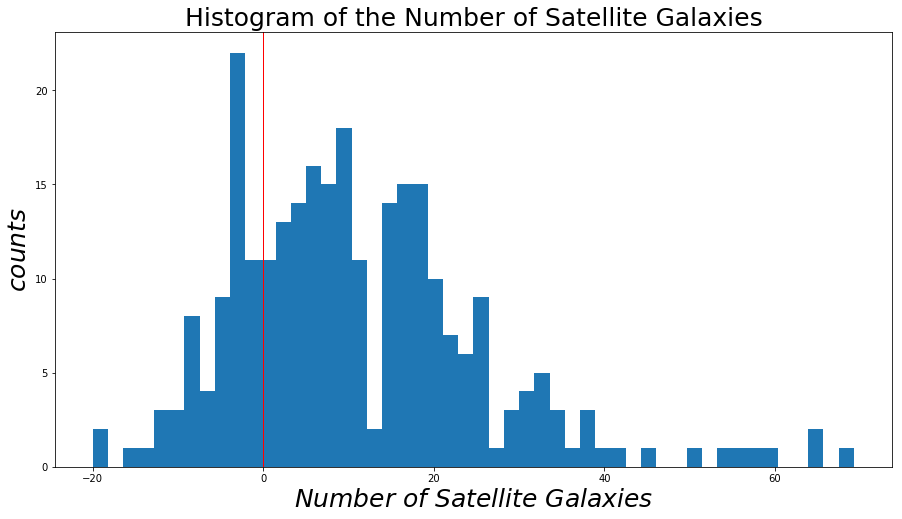

In [83]:
totalNsat(newNsat4)

# plt.savefig('/Users/mtownsend/Desktop/maskedNsat4.jpg')
plt.show()

mean number of satellites is 7.432874222431259
median number of satellites is 6.786229543729247
standard deviation of satellites is 11.122996304306188
standard error is 0.5453497615892084


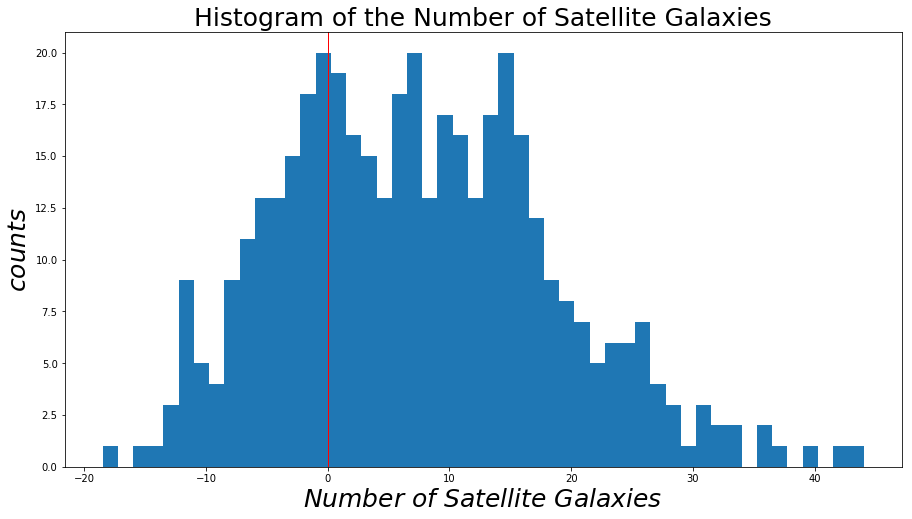

In [84]:
totalNsat(newNsat5)

# plt.savefig('/Users/mtownsend/Desktop/maskedNsat5.jpg')
plt.show()

mean number of satellites is 8.318971312083528
median number of satellites is 6.394397433098142
standard deviation of satellites is 11.142175260409392
standard error is 0.5753794563211982


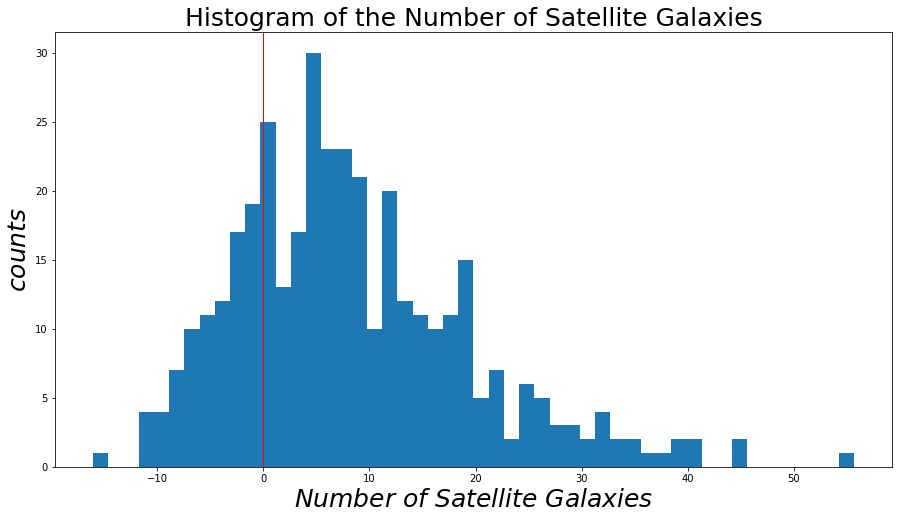

In [85]:
totalNsat(newNsat6)

# plt.savefig('/Users/mtownsend/Desktop/maskedNsat6.jpg')
plt.show()

mean number of satellites is 9.05950399447518
median number of satellites is 8.011695310391435
standard deviation of satellites is 10.199913909330885
standard error is 0.6908253399123122


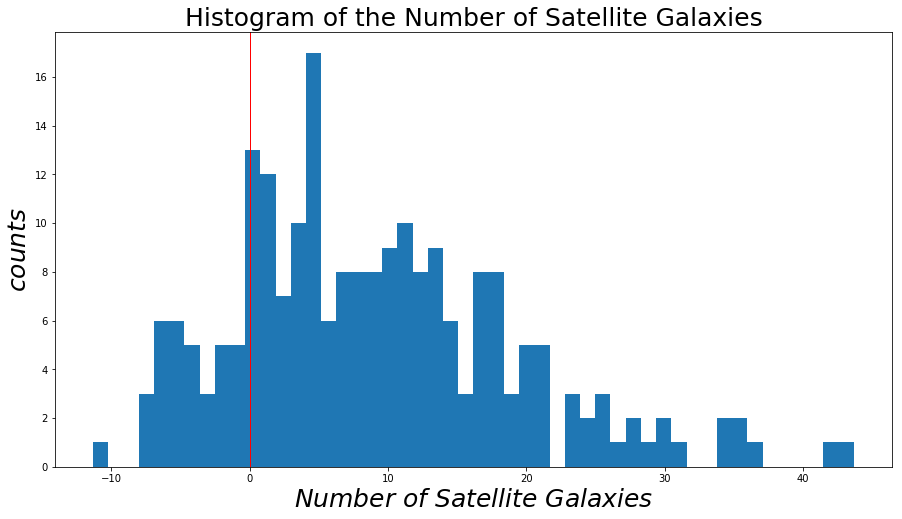

In [86]:
totalNsat(newNsat7)

# plt.savefig('/Users/mtownsend/Desktop/maskedNsat7.jpg')
plt.show()

In [48]:
# Divvy up by redshift slice

zinit = 0.2
zfin = 0.65
interval = 0.05
num = (zfin-zinit)/interval
zrange, step = np.linspace(zinit, zfin, num=int(num), retstep=True)
print(zrange)

Nsat_zcut1 = Nsat[np.where((z_LRG >= zrange[0]) & (z_LRG < zrange[1]))]
Nsat_zcut2 = Nsat[np.where((z_LRG >= zrange[1]) & (z_LRG < zrange[2]))]
Nsat_zcut3 = Nsat[np.where((z_LRG >= zrange[2]) & (z_LRG < zrange[3]))]
Nsat_zcut4 = Nsat[np.where((z_LRG >= zrange[3]) & (z_LRG < zrange[4]))]
Nsat_zcut5 = Nsat[np.where((z_LRG >= zrange[4]) & (z_LRG < zrange[5]))]
Nsat_zcut6 = Nsat[np.where((z_LRG >= zrange[5]) & (z_LRG < zrange[6]))]
Nsat_zcut7 = Nsat[np.where((z_LRG >= zrange[6]) & (z_LRG < zrange[7]))]
Nsat_zcut8 = Nsat[np.where((z_LRG >= zrange[7]) & (z_LRG <= zrange[8]))]

zmag_LRG_zcut1 = zmag_LRG[np.where((z_LRG >= zrange[0]) & (z_LRG < zrange[1]))]
zmag_LRG_zcut2 = zmag_LRG[np.where((z_LRG >= zrange[1]) & (z_LRG < zrange[2]))]
zmag_LRG_zcut3 = zmag_LRG[np.where((z_LRG >= zrange[2]) & (z_LRG < zrange[3]))]
zmag_LRG_zcut4 = zmag_LRG[np.where((z_LRG >= zrange[3]) & (z_LRG < zrange[4]))]
zmag_LRG_zcut5 = zmag_LRG[np.where((z_LRG >= zrange[4]) & (z_LRG < zrange[5]))]
zmag_LRG_zcut6 = zmag_LRG[np.where((z_LRG >= zrange[5]) & (z_LRG < zrange[6]))]
zmag_LRG_zcut7 = zmag_LRG[np.where((z_LRG >= zrange[6]) & (z_LRG < zrange[7]))]
zmag_LRG_zcut8 = zmag_LRG[np.where((z_LRG >= zrange[7]) & (z_LRG <= zrange[8]))]

rzcolor_LRG_zcut1 = rzcolor_LRG[np.where((z_LRG >= zrange[0]) & (z_LRG < zrange[1]))]
rzcolor_LRG_zcut2 = rzcolor_LRG[np.where((z_LRG >= zrange[1]) & (z_LRG < zrange[2]))]
rzcolor_LRG_zcut3 = rzcolor_LRG[np.where((z_LRG >= zrange[2]) & (z_LRG < zrange[3]))]
rzcolor_LRG_zcut4 = rzcolor_LRG[np.where((z_LRG >= zrange[3]) & (z_LRG < zrange[4]))]
rzcolor_LRG_zcut5 = rzcolor_LRG[np.where((z_LRG >= zrange[4]) & (z_LRG < zrange[5]))]
rzcolor_LRG_zcut6 = rzcolor_LRG[np.where((z_LRG >= zrange[5]) & (z_LRG < zrange[6]))]
rzcolor_LRG_zcut7 = rzcolor_LRG[np.where((z_LRG >= zrange[6]) & (z_LRG < zrange[7]))]
rzcolor_LRG_zcut8 = rzcolor_LRG[np.where((z_LRG >= zrange[7]) & (z_LRG <= zrange[8]))]

print(len(Nsat_zcut1))
print(len(Nsat_zcut2))
print(len(Nsat_zcut3))
print(len(Nsat_zcut4))
print(len(Nsat_zcut5))

print(Nsat_zcut1.shape)

[0.2     0.25625 0.3125  0.36875 0.425   0.48125 0.5375  0.59375 0.65   ]
113
88
173
166
271
(113, 49, 49, 49)


(49, 49, 49)


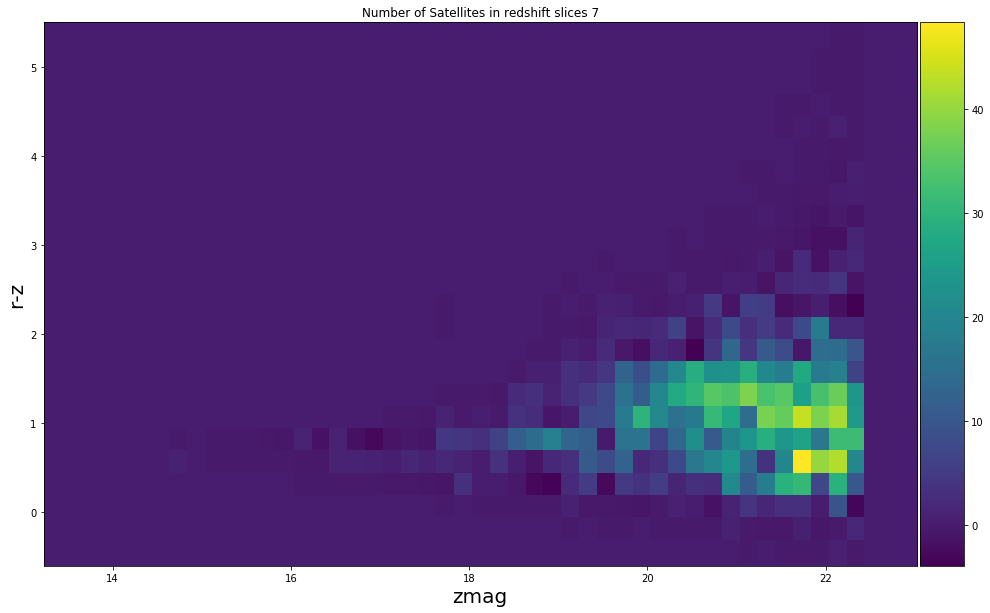

In [71]:
rz_v_zmag = Nsat_zcut8[:, :, :].sum(axis=0)
# rz_vs_zmag = np.fliplr(rz_v_zmag)
print(rz_v_zmag.shape)
rz_v_zmag = rz_v_zmag[:, :, :].sum(axis=2)

plt.figure()
ax = plt.gca()
im = ax.imshow(rz_v_zmag, extent=(zmag_edges[0], zmag_edges[-1], rz_edges[0], rz_edges[-1]), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title("Number of Satellites in redshift slices 7")
ax.set_ylim([-0.6,5.5])
ax.set_xlabel('zmag',fontsize=20)
ax.set_ylabel('r-z',fontsize=20)
plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/30April2020/Nsat_2D_hist7-v1.pdf'.format(i))   
plt.show()


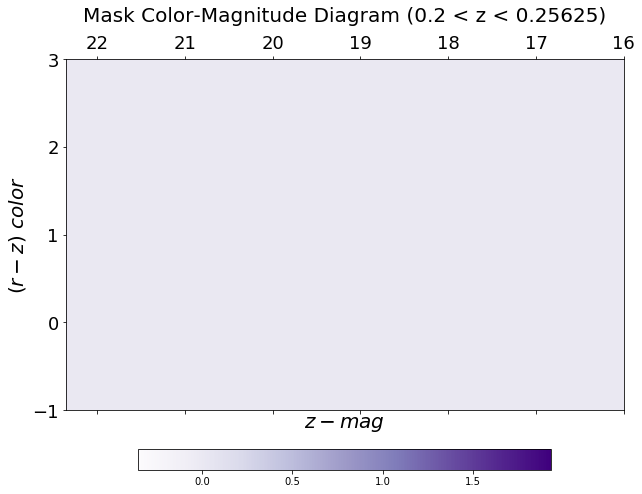

In [59]:
def cmdHistograms(H, edges, zmag_LRG, rzcolor_LRG):

    # This function plots a color-magnitude 2D histogram for satellites around LRG; produces a histogram for every LRG

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib import colors

    plt.rcParams.update({'figure.max_open_warning': 0})

    rz_zmag_sum = list(np.zeros((49,49)))
    gr_zmag_sum = list(np.zeros((49,49)))
    gr_rz_sum = list(np.zeros((49,49)))
    for i in range(len(H)):
        # make 2D projections of 3D histogram
        rz_v_zmag = H[i][:, :, :].sum(axis=2)
#         rz_vs_zmag = np.flipud(rz_v_zmag)
#         rz_zmag_sum = np.add(rz_zmag_sum, rz_vs_zmag)
#         gr_v_zmag = H[i][:, :, :].sum(axis=0)
#         gr_vs_zmag = np.flipud(gr_v_zmag.T)
#         gr_zmag_sum = np.add(gr_zmag_sum, gr_vs_zmag)
#         gr_v_rz = H[i][:, :, :].sum(axis=1)
#         gr_vs_rz = np.flipud(gr_v_rz.T)
#         gr_rz_sum = np.add(gr_rz_sum, gr_vs_rz)
        

        # plot 2D histograms using matshow; 3 plots per image
#         f, axarr = plt.subplots(111, figsize=(10, 10))
#         f.suptitle("Satellite Density CMD (LRG {})".format(i))

    plt.rcParams["figure.figsize"] = [40, 10]
    im1 = plt.matshow(rz_v_zmag, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[edges[1][0], edges[1][len(edges[1]) - 1], edges[0][0], edges[0][len(edges[0]) - 1]])
#     plt.scatter(zmag_LRG, rzcolor_LRG, s=4, color='red', label="LRG")
    plt.title("Mask Color-Magnitude Diagram (0.2 < z < 0.25625)".format(i), fontsize=20, pad=20)
#         plt.xaxis.set_ticks_position('bottom')
#         plt.invert_xaxis()
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    plt.gca().invert_xaxis()
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.xlim(22.36, 16)
    plt.ylim(-1, 3)
#         plt.set(xlabel='zmag', ylabel='(r-z)')
#         plt.set_ylim(bottom=-5, top=5)
    plt.colorbar(im1, orientation="horizontal", fraction=0.037, pad=0.07)
#         s = 'LRG redshift: {0:.2f}'.format(z_LRG[i])
#         t = 'LRG coords: {:.2f}, {:.2f}'.format(ra_LRG[i], dec_LRG[i])
#         plt.text(16, -2, s, family='sans-serif', fontsize=14)
#         plt.text(16, -2.5, t, family='sans-serif', fontsize=14)
#         axarr[0].title("Satellite Color-Magnitude Diagram (LRG {})".format(i), fontsize=15)
    plt.xlabel(r'$z-mag$', fontsize=20)
    plt.ylabel(r'$(r-z)$ $color$', fontsize=20)
#     plt.legend(loc='upper right', prop={'size': 20}, markerscale=5.0)

        # save image with incrementing file name
#     plt.savefig('/Users/mtownsend/Desktop/compareCMDs/maskHistCMD-zslice1-v1.pdf'.format(i))    
    plt.show()
    

rz_edges = [-1.8027077, -1.5527076721191406, -1.3027076721191406, -1.0527076721191406, -0.8027076721191406, -0.5527076721191406, -0.3027076721191406, -0.052707672119140625, 0.19729232788085938, 0.4472923278808594, 0.6972923278808594, 0.9472923278808594, 1.1972923278808594, 1.4472923278808594, 1.6972923278808594, 1.9472923278808594, 2.1972923278808594, 2.4472923278808594, 2.6972923278808594, 2.9472923278808594, 3.1972923278808594, 3.4472923278808594, 3.6972923278808594, 3.9472923278808594, 4.197292327880859, 4.447292327880859, 4.697292327880859, 4.947292327880859, 5.197292327880859, 5.447292327880859, 5.697292327880859, 5.947292327880859, 6.197292327880859, 6.447292327880859, 6.697292327880859, 6.947292327880859, 7.197292327880859, 7.447292327880859, 7.697292327880859, 7.947292327880859, 8.19729232788086, 8.44729232788086, 8.69729232788086, 8.94729232788086, 9.19729232788086, 9.44729232788086, 9.69729232788086, 9.94729232788086, 10.19729232788086, 10.44729232788086]
zmag_edges = [13.22509, 13.425090026855468, 13.625090026855467, 13.825090026855467, 14.025090026855466, 14.225090026855465, 14.425090026855464, 14.625090026855464, 14.825090026855463, 15.025090026855462, 15.225090026855462, 15.425090026855461, 15.62509002685546, 15.82509002685546, 16.02509002685546, 16.225090026855458, 16.425090026855457, 16.625090026855457, 16.825090026855456, 17.025090026855455, 17.225090026855455, 17.425090026855454, 17.625090026855453, 17.825090026855452, 18.02509002685545, 18.22509002685545, 18.42509002685545, 18.62509002685545, 18.82509002685545, 19.025090026855448, 19.225090026855447, 19.425090026855447, 19.625090026855446, 19.825090026855445, 20.025090026855445, 20.225090026855444, 20.425090026855443, 20.625090026855442, 20.82509002685544, 21.02509002685544, 21.22509002685544, 21.42509002685544, 21.62509002685544, 21.825090026855438, 22.025090026855437, 22.225090026855437, 22.425090026855436, 22.625090026855435, 22.825090026855435, 23.025090026855434]
gr_edges = [-6.5846786, -6.234678649902344, -5.8846786499023445, -5.534678649902345, -5.184678649902345, -4.8346786499023455, -4.484678649902346, -4.134678649902346, -3.784678649902346, -3.434678649902346, -3.084678649902346, -2.734678649902346, -2.384678649902346, -2.0346786499023457, -1.6846786499023456, -1.3346786499023455, -0.9846786499023455, -0.6346786499023456, -0.2846786499023456, 0.06532135009765438, 0.41532135009765436, 0.7653213500976543, 1.1153213500976542, 1.4653213500976543, 1.8153213500976544, 2.1653213500976545, 2.5153213500976546, 2.8653213500976547, 3.2153213500976547, 3.565321350097655, 3.915321350097655, 4.265321350097655, 4.615321350097655, 4.965321350097654, 5.315321350097654, 5.665321350097654, 6.015321350097653, 6.365321350097653, 6.7153213500976525, 7.065321350097652, 7.415321350097652, 7.7653213500976515, 8.115321350097652, 8.465321350097652, 8.815321350097651, 9.165321350097651, 9.51532135009765, 9.86532135009765, 10.21532135009765, 10.56532135009765]
    
# cmdHistograms(Nsat_zcut1, nouse_edges, zmag_LRG_zcut1, rzcolor_LRG_zcut1)
# cmdHistograms(Nsat_zcut2, nouse_edges, zmag_LRG_zcut2, rzcolor_LRG_zcut2)
# cmdHistograms(Nsat_zcut3, nouse_edges, zmag_LRG_zcut3, rzcolor_LRG_zcut3)
# cmdHistograms(Nsat_zcut4, nouse_edges, zmag_LRG_zcut4, rzcolor_LRG_zcut4)
# cmdHistograms(Nsat_zcut5, nouse_edges, zmag_LRG_zcut5, rzcolor_LRG_zcut5)
# cmdHistograms(Nsat_zcut6, nouse_edges, zmag_LRG_zcut6, rzcolor_LRG_zcut6)
# cmdHistograms(Nsat_zcut7, nouse_edges, zmag_LRG_zcut7, rzcolor_LRG_zcut7)
cmdHistograms(Nsat_zcut8, nouse_edges, zmag_LRG_zcut8, rzcolor_LRG_zcut8)

# cmdHistograms(d0, nouse_edges, zmag_LRG_zcut1, rzcolor_LRG_zcut1)
# cmdHistograms(data['mask1'], nouse_edges, zmag_LRG_zcut2, rzcolor_LRG_zcut2)
# cmdHistograms(data['mask2'], nouse_edges, zmag_LRG_zcut3, rzcolor_LRG_zcut3)
# cmdHistograms(data['mask3'], nouse_edges, zmag_LRG_zcut4, rzcolor_LRG_zcut4)
# cmdHistograms(data['mask4'], nouse_edges, zmag_LRG_zcut5, rzcolor_LRG_zcut5)
# cmdHistograms(data['mask5'], nouse_edges, zmag_LRG_zcut6, rzcolor_LRG_zcut6)
# cmdHistograms(data['mask6'], nouse_edges, zmag_LRG_zcut7, rzcolor_LRG_zcut7)
# cmdHistograms(data['mask7'], nouse_edges, zmag_LRG_zcut8, rzcolor_LRG_zcut8)

# [0.2     0.25625 0.3125  0.36875 0.425   0.48125 0.5375  0.59375 0.65   ]




In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

print(np.where(d1 == 1.))


plt.rcParams["figure.figsize"] = [40, 10]
im1 = plt.matshow(rz_vs_zmag, cmap=plt.cm.Purples, norm=colors.Normalize(), extent=[nouse_edges[1][0], nouse_edges[1][len(nouse_edges[1]) - 1], nouse_edges[0][0], nouse_edges[0][len(nouse_edges[0]) - 1]])
# plt.scatter(zmag_LRG, rzcolor_LRG, s=4, color='red', label="LRG")
plt.title("Mask Color-Magnitude Diagram (0.59375 < z < 0.65)".format(i), fontsize=20, pad=20)
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
# plt.gca().invert_xaxis()
plt.tick_params(axis='both', which='major', labelsize=18)
# plt.xlim(22.36, 16)
# plt.ylim(-1, 3)
plt.colorbar(im1, orientation="horizontal", fraction=0.037, pad=0.07)
plt.xlabel(r'$z-mag$', fontsize=20)
plt.ylabel(r'$(r-z)$ $color$', fontsize=20)
# plt.legend(loc='upper right', prop={'size': 20}, markerscale=5.0)

# save image with incrementing file name
# plt.savefig('/Users/mtownsend/Desktop/compareCMDs/maskHistCMD-zslice7-v1.pdf'.format(i))    
plt.show()

NameError: name 'd1' is not defined